In [ ]:
import rasterio
import numpy as np
import os

image_folder = '/content/drive/MyDrive/Colab Notebooks/tiles'
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])

print("Checking tile shapes...")
shapes = {}
problem_files = []

for i, f in enumerate(image_files[:100]):
    try:
        with rasterio.open(os.path.join(image_folder, f)) as src:
            shape = (src.count, src.height, src.width)
            if shape not in shapes:
                shapes[shape] = []
            shapes[shape].append(f)
    except Exception as e:
        problem_files.append((f, str(e)))

print("\nShape distribution:")
for shape, files in shapes.items():
    print(f"  Shape {shape}: {len(files)} files")

if problem_files:
    print(f"\nProblem files: {len(problem_files)}")
    for f, err in problem_files[:5]:
        print(f"  {f}: {err}")

Checking tile shapes...

Shape distribution:
  Shape (4, 512, 512): 96 files
  Shape (4, 512, 228): 4 files


In [ ]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt

image_folder = '/content/drive/MyDrive/Colab Notebooks/tiles'
mask_folder = '/content/drive/MyDrive/Colab Notebooks/tiles_masks'

valid_pairs = []
for f in os.listdir(image_folder):
    if not f.endswith('.tif'):
        continue

    img_path = os.path.join(image_folder, f)
    mask_path = os.path.join(mask_folder, f.replace('.tif', '_mask.tif'))

    if not os.path.exists(mask_path):
        print(f"Mask missing for {f}")
        continue

    with rasterio.open(img_path) as src:
        if src.height == 512 and src.width == 512:
            valid_pairs.append(f)

print(f"Found {len(valid_pairs)} valid image-mask pairs")

X = []
y = []

for i, f in enumerate(valid_pairs[:100]):
    with rasterio.open(os.path.join(image_folder, f)) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    mask_f = f.replace('.tif', '_mask.tif')
    with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
        mask = src.read(1)

    assert img.shape[:2] == (512, 512), f"Image wrong shape: {img.shape}"
    assert mask.shape == (512, 512), f"Mask wrong shape: {mask.shape}"

    X.append(img)
    y.append(mask)

    if i % 20 == 0:
        print(f"Loaded {i}/{len(valid_pairs[:100])}")

X = np.array(X)
y = np.array(y)

print(f"\nSUCCESS!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

unique_vals = np.unique(y)
print(f"Mask unique values: {unique_vals}")

idx = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(X[idx][:,:,:3])
ax1.set_title('Image')
ax2.imshow(y[idx], cmap='tab10', vmin=0, vmax=2)
ax2.set_title('Mask')
plt.show()

Found 441 valid image-mask pairs


AssertionError: Mask wrong shape: (10, 10)

In [ ]:
import os
import rasterio

mask_folder = '/content/drive/MyDrive/Colab Notebooks/tiles_masks'

# Check first 20 mask files
print("Mask file dimensions:")
small_masks = 0
for i, f in enumerate(sorted(os.listdir(mask_folder))[:484]):
    if f.endswith('_mask.tif'):
        with rasterio.open(os.path.join(mask_folder, f)) as src:
            size = (src.height, src.width)
            print(f"{f}: {size}")
            if size != (512, 512):
                small_masks += 1

print(f"\nFound {small_masks} small masks in first 20")

Mask file dimensions:
rasterlayer_01_01_mask.tif: (10, 10)
rasterlayer_01_02_mask.tif: (10, 10)
rasterlayer_01_03_mask.tif: (10, 10)
rasterlayer_01_04_mask.tif: (10, 10)
rasterlayer_01_05_mask.tif: (10, 10)
rasterlayer_01_06_mask.tif: (10, 10)
rasterlayer_01_07_mask.tif: (10, 10)
rasterlayer_01_08_mask.tif: (10, 10)
rasterlayer_01_09_mask.tif: (10, 10)
rasterlayer_01_10_mask.tif: (10, 10)
rasterlayer_01_11_mask.tif: (10, 10)
rasterlayer_01_12_mask.tif: (10, 10)
rasterlayer_01_13_mask.tif: (10, 10)
rasterlayer_01_14_mask.tif: (10, 10)
rasterlayer_01_15_mask.tif: (10, 10)
rasterlayer_01_16_mask.tif: (10, 10)
rasterlayer_01_17_mask.tif: (10, 10)
rasterlayer_01_18_mask.tif: (10, 10)
rasterlayer_01_19_mask.tif: (10, 10)
rasterlayer_01_20_mask.tif: (10, 10)
rasterlayer_01_21_mask.tif: (10, 10)
rasterlayer_01_22_mask.tif: (10, 10)
rasterlayer_02_01_mask.tif: (10, 10)
rasterlayer_02_02_mask.tif: (10, 10)
rasterlayer_02_03_mask.tif: (10, 10)
rasterlayer_02_04_mask.tif: (10, 10)
rasterlayer_02_0

In [ ]:
with rasterio.open("/content/drive/MyDrive/Colab Notebooks/rasterlayer_01_01_mask.tif") as src:
    print(f"Test mask shape: {src.height} x {src.width}")
    print(f"Should be: 512 x 512")

Test mask shape: 10 x 10
Should be: 512 x 512


In [ ]:


import rasterio
import numpy as np
from collections import Counter

mask_folder = '/content/drive/MyDrive/Colab Notebooks/tiles_masks'
mask_files = [f for f in os.listdir(mask_folder) if f.endswith('_mask.tif')]

masks_with_crops = 0
total_pixels = 0
crop_pixels = 0

for i, mask_f in enumerate(mask_files[:484]):  # Check first 50
    with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
        mask = src.read(1)
        unique, counts = np.unique(mask, return_counts=True)

        print(f"\n{mask_f}:")
        for u, c in zip(unique, counts):
            print(f"  Class {u}: {c} pixels ({c/mask.size*100:.2f}%)")

            if u in [1, 2]:
                masks_with_crops += 1
                crop_pixels += c
        total_pixels += mask.size
print(f"Masks with crop pixels: {masks_with_crops}/{484}")
print(f"Total crop pixels: {crop_pixels}")
print(f"Percentage crop: {crop_pixels/total_pixels*100:.4f}%")

Checking mask files for crop pixels...

rasterlayer_22_22_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_20_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_19_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_18_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_21_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_16_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_17_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_14_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_15_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_12_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_13_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_11_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_10_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_08_mask.tif:
  Class 0: 262144 pixels (100.00%)

rasterlayer_22_09_mask.tif:
  Class 0: 262144 pixels (100.00%)



Training on 158 crop pixels only


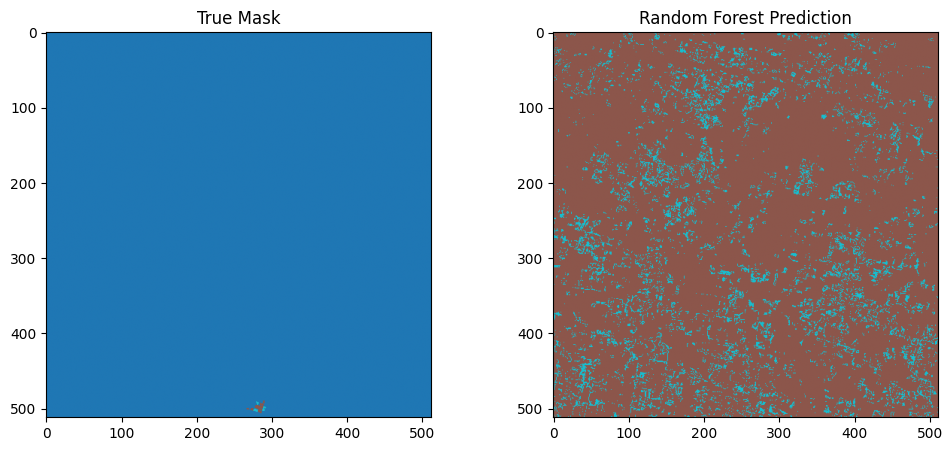

In [ ]:

from sklearn.ensemble import RandomForestClassifier
import numpy as np

crop_tile = 'rasterlayer_05_19.tif'


import matplotlib.pyplot as plt
import rasterio
import numpy as np

image_path = f'/content/drive/MyDrive/Colab Notebooks/tiles/{crop_tile}'
mask_path = f'/content/drive/MyDrive/Colab Notebooks/tiles_masks/{crop_tile.replace(".tif", "_mask.tif")}'

with rasterio.open(image_path) as src:
    img = src.read()
    img = img / 10000.0

with rasterio.open(mask_path) as src:
    mask = src.read(1)

X = img.reshape(4, -1).T
y = mask.flatten()

crop_mask = y > 0
X_crop = X[crop_mask]
y_crop = y[crop_mask]

print(f"Training on {len(X_crop)} crop pixels only")

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_crop, y_crop)

y_pred = rf.predict(X)
y_pred_img = y_pred.reshape(512, 512)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(mask, cmap='tab10', vmin=0, vmax=2)
ax1.set_title('True Mask')
ax2.imshow(y_pred_img, cmap='tab10', vmin=0, vmax=2)
ax2.set_title('Random Forest Prediction')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🌾 TWO-STAGE WHEAT vs MUSTARD SEGMENTATION
Using 8 tiles with crops

📊 Loading all available tiles...
Total tiles available: 1518
Stage 1 training: 50 tiles (8 with crops, 42 empty)


Loading stage 1 data: 100%|██████████| 50/50 [00:09<00:00,  5.31it/s]



Stage 1 data shape: (50, 256, 256, 4)
Class distribution: Counter({np.int64(0): 48, np.int64(1): 2})

STAGE 1: TRAINING CROP DETECTION MODEL
Stage 1 - Training: 40, Validation: 10


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,857 (397.88 KB)

 Trainable params: 101,857 (397.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9399 - loss: 0.6047 - val_accuracy: 1.0000 - val_loss: 0.3866
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9660 - loss: 0.3261 - val_accuracy: 1.0000 - val_loss: 0.1980
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9556 - loss: 0.2591 - val_accuracy: 1.0000 - val_loss: 0.1390
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9278 - loss: 0.4235 - val_accuracy: 1.0000 - val_loss: 0.1382
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9347 - loss: 0.2760 - val_accuracy: 1.0000 - val_loss: 0.1104
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9781 - loss: 0.1647 - val_accuracy: 1.0000 - val_loss: 0.0530
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9399 - loss: 0.2352 - val_accuracy: 1.0000 - val_loss: 0.0542
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9347 - loss: 0.2185 - val_accuracy: 1.0000 - val_loss: 0.0471

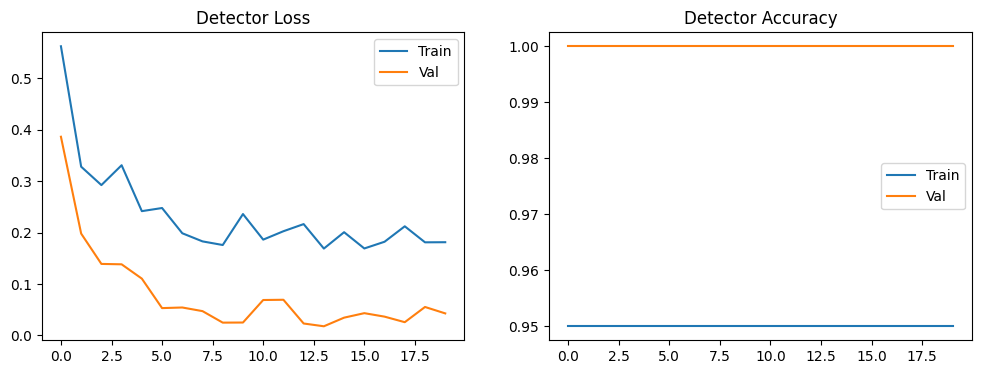


STAGE 2: PREPARING SEGMENTATION DATA


Loading crop tiles: 100%|██████████| 8/8 [00:00<00:00, 20.94it/s]


Stage 2 data shape: (8, 256, 256, 4)
Stage 2 masks shape: (8, 256, 256)

📦 Creating balanced patches...
Created 300 patches of size 64x64
Patches shape: (300, 64, 64, 4)
Patches mask shape: (300, 64, 64)

Class distribution in patches:
  Class 0: 1127936 pixels (91.79%)
  Class 1: 84017 pixels (6.84%)
  Class 2: 16847 pixels (1.37%)

Patches - Training: 240, Validation: 60

STAGE 2: BUILDING SEGMENTATION MODEL


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │      1,184 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_36[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32, 32,    │          0 │ up_sampling2d_6[… │
│ (Concatenate)       │ 192)              │            │ conv2d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 64, 64,    │          0 │ conv2d_43[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 64, 64,    │          0 │ up_sampling2d_7[… │
│ (Concatenate)       │ 96)               │            │ conv2d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64,    │     27,680 │ concatenate_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_44[0][0] 

 Total params: 471,907 (1.80 MB)

 Trainable params: 471,907 (1.80 MB)

 Non-trainable params: 0 (0.00 B)


Class weights: {np.uint8(0): np.float64(0.3651636873419654), np.uint8(1): np.float64(4.567477906944328), np.uint8(2): np.float64(23.494658349465833)}

🚀 Training segmentation model on patches...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.0937 - loss: 1.1793

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1026 - loss: 1.1703 - val_accuracy: 0.8880 - val_loss: 1.0756 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6449 - loss: 1.0903 - val_accuracy: 0.1173 - val_loss: 1.2180 - learning_rate: 0.0010
Epoch 3/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2606 - loss: 1.0226

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2839 - loss: 1.0222 - val_accuracy: 0.6943 - val_loss: 0.7604 - learning_rate: 0.0010
Epoch 4/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4434 - loss: 1.0895

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4426 - loss: 1.0664 - val_accuracy: 0.8362 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6607 - loss: 0.9283 - val_accuracy: 0.5189 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5152 - loss: 0.8925 - val_accuracy: 0.6405 - val_loss: 0.7034 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5238 - loss: 0.8535 - val_accuracy: 0.6292 - val_loss: 0.7324 - learning_rate: 0.0010
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6317 - loss: 0.7398 - val_accuracy: 0.6614 - val_loss: 0.7616 - learning_rate: 0.0010
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6830 - loss: 0.6686 - val_accuracy: 0.7553 - val_loss: 0.5947 - learning_rate: 0.0010
Epoch 10/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7598 - loss: 0.5971

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7609 - loss: 0.5860 - val_accuracy: 0.8907 - val_loss: 0.3024 - learning_rate: 5.0000e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7903 - loss: 0.5749 - val_accuracy: 0.8074 - val_loss: 0.4862 - learning_rate: 5.0000e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8203 - loss: 0.4672 - val_accuracy: 0.8448 - val_loss: 0.4098 - learning_rate: 5.0000e-04
Epoch 13/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8492 - loss: 0.4560

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8489 - loss: 0.4483 - val_accuracy: 0.9179 - val_loss: 0.2287 - learning_rate: 5.0000e-04
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8696 - loss: 0.3987 - val_accuracy: 0.8514 - val_loss: 0.4033 - learning_rate: 5.0000e-04
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8622 - loss: 0.3790 - val_accuracy: 0.8749 - val_loss: 0.3423 - learning_rate: 5.0000e-04
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8851 - loss: 0.3299 - val_accuracy: 0.8890 - val_loss: 0.3086 - learning_rate: 5.0000e-04
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9080 - loss: 0.2992 - val_accuracy: 0.8314 - val_loss: 0.4779 - learning_rate: 5.0000e-04
Epoch 18/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8867 - loss: 0.2961

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8898 - loss: 0.2961 - val_accuracy: 0.9326 - val_loss: 0.1943 - learning_rate: 5.0000e-04
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9195 - loss: 0.2772 - val_accuracy: 0.9190 - val_loss: 0.2286 - learning_rate: 5.0000e-04
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9292 - loss: 0.2438 - val_accuracy: 0.9331 - val_loss: 0.1949 - learning_rate: 5.0000e-04
Epoch 21/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9389 - loss: 0.2036

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9385 - loss: 0.2070 - val_accuracy: 0.9421 - val_loss: 0.1736 - learning_rate: 5.0000e-04
Epoch 22/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9372 - loss: 0.2182

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9386 - loss: 0.2145 - val_accuracy: 0.9447 - val_loss: 0.1709 - learning_rate: 5.0000e-04
Epoch 23/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9457 - loss: 0.1904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9464 - loss: 0.1880 - val_accuracy: 0.9543 - val_loss: 0.1407 - learning_rate: 5.0000e-04
Epoch 24/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9496 - loss: 0.1709 - val_accuracy: 0.9137 - val_loss: 0.2574 - learning_rate: 5.0000e-04
Epoch 25/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9348 - loss: 0.1829 - val_accuracy: 0.9314 - val_loss: 0.2027 - learning_rate: 5.0000e-04
Epoch 26/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9212 - loss: 0.2370 - val_accuracy: 0.9502 - val_loss: 0.1502 - learning_rate: 5.0000e-04
Epoch 27/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9393 - loss: 0.1980

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9394 - loss: 0.1969 - val_accuracy: 0.9592 - val_loss: 0.1235 - learning_rate: 5.0000e-04
Epoch 28/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9486 - loss: 0.1795

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9488 - loss: 0.1779 - val_accuracy: 0.9647 - val_loss: 0.1092 - learning_rate: 5.0000e-04
Epoch 29/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9571 - loss: 0.1494 - val_accuracy: 0.9589 - val_loss: 0.1276 - learning_rate: 5.0000e-04
Epoch 30/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9606 - loss: 0.1341

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9603 - loss: 0.1350 - val_accuracy: 0.9723 - val_loss: 0.0883 - learning_rate: 5.0000e-04
Epoch 31/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9657 - loss: 0.1238 - val_accuracy: 0.9671 - val_loss: 0.1045 - learning_rate: 5.0000e-04
Epoch 32/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9618 - loss: 0.1307 - val_accuracy: 0.9640 - val_loss: 0.1172 - learning_rate: 5.0000e-04
Epoch 33/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9619 - loss: 0.1249 - val_accuracy: 0.9699 - val_loss: 0.0979 - learning_rate: 5.0000e-04
Epoch 34/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9652 - loss: 0.1134 - val_accuracy: 0.9659 - val_loss: 0.1074 - learning_rate: 5.0000e-04
Epoch 35/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9652 - loss: 0.1093 - val_accuracy: 0.9694 - val_loss: 0.1004 - learning_rate: 5.0000e-04
Epoch 36/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9684 - loss: 0.1025 - va

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9691 - loss: 0.0965 - val_accuracy: 0.9736 - val_loss: 0.0864 - learning_rate: 2.5000e-04
Epoch 38/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9720 - loss: 0.0929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9718 - loss: 0.0927 - val_accuracy: 0.9755 - val_loss: 0.0799 - learning_rate: 2.5000e-04
Epoch 39/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9704 - loss: 0.0901 - val_accuracy: 0.9730 - val_loss: 0.0873 - learning_rate: 2.5000e-04
Epoch 40/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9715 - loss: 0.0844 - val_accuracy: 0.9742 - val_loss: 0.0845 - learning_rate: 2.5000e-04
Epoch 41/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9701 - loss: 0.0879

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9707 - loss: 0.0865 - val_accuracy: 0.9769 - val_loss: 0.0758 - learning_rate: 2.5000e-04
Epoch 42/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9713 - loss: 0.0861 - val_accuracy: 0.9736 - val_loss: 0.0873 - learning_rate: 2.5000e-04
Epoch 43/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9726 - loss: 0.0775 - val_accuracy: 0.9764 - val_loss: 0.0773 - learning_rate: 2.5000e-04
Epoch 44/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9721 - loss: 0.0799

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9723 - loss: 0.0792 - val_accuracy: 0.9784 - val_loss: 0.0721 - learning_rate: 2.5000e-04
Epoch 45/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9727 - loss: 0.0780 - val_accuracy: 0.9778 - val_loss: 0.0738 - learning_rate: 2.5000e-04
Epoch 46/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9750 - loss: 0.0705 - val_accuracy: 0.9747 - val_loss: 0.0849 - learning_rate: 2.5000e-04
Epoch 47/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9736 - loss: 0.0695

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9737 - loss: 0.0697 - val_accuracy: 0.9789 - val_loss: 0.0700 - learning_rate: 2.5000e-04
Epoch 48/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9775 - loss: 0.0637 - val_accuracy: 0.9783 - val_loss: 0.0726 - learning_rate: 2.5000e-04
Epoch 49/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9755 - loss: 0.0663

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9754 - loss: 0.0668 - val_accuracy: 0.9812 - val_loss: 0.0634 - learning_rate: 2.5000e-04
Epoch 50/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9734 - loss: 0.0762

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9734 - loss: 0.0757 - val_accuracy: 0.9819 - val_loss: 0.0629 - learning_rate: 2.5000e-04


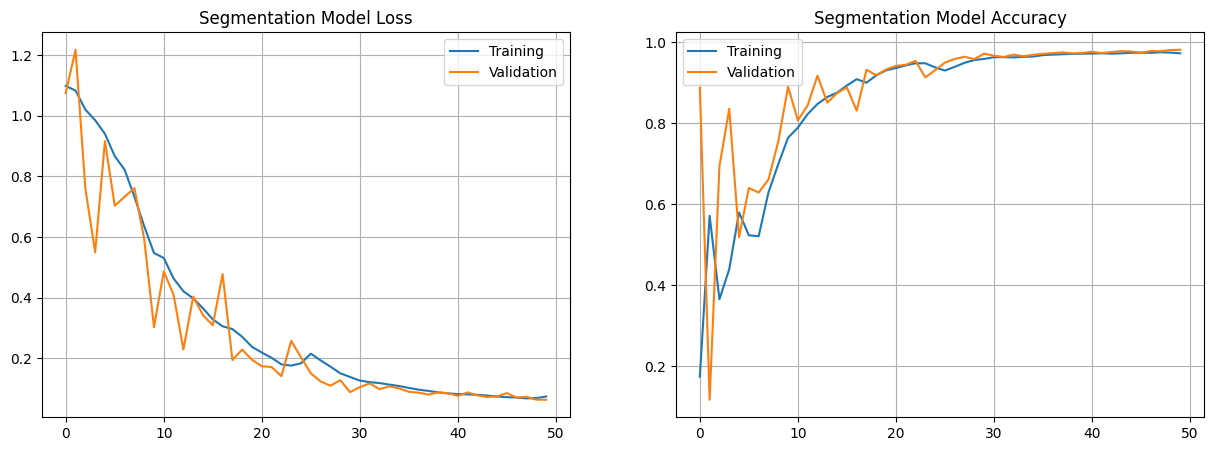


TESTING ON FULL TILES


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('int64') to dtype('uint8') with casting rule 'same_kind'

In [ ]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
import random
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

image_folder = '/content/drive/MyDrive/Colab Notebooks/tiles_256/'
mask_folder = '/content/drive/MyDrive/Colab Notebooks/masks_256/'

crop_tiles = [
    'rasterlayer_09_37.tif',
    'rasterlayer_09_38.tif',
    'rasterlayer_10_37.tif',
    'rasterlayer_10_38.tif',
    'rasterlayer_11_37.tif',
    'rasterlayer_11_38.tif',
    'rasterlayer_12_37.tif',
    'rasterlayer_12_38.tif'
]

all_tile_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
empty_tiles = [f for f in all_tile_files if f not in crop_tiles]

random.seed(42)
selected_empty = random.sample(empty_tiles, min(42, len(empty_tiles)))
stage1_tiles = crop_tiles + selected_empty

X_stage1 = []
y_stage1_labels = []

for tile_f in tqdm(stage1_tiles, desc="Loading stage 1 data"):
    with rasterio.open(os.path.join(image_folder, tile_f)) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))
        X_stage1.append(img)

    mask_f = tile_f.replace('.tif', '_mask.tif')
    if os.path.exists(os.path.join(mask_folder, mask_f)):
        with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
            mask = src.read(1)
            has_crops = 1 if np.any(mask > 0) else 0
    else:
        has_crops = 0
    y_stage1_labels.append(has_crops)

X_stage1 = np.array(X_stage1, dtype=np.float32)
y_stage1_labels = np.array(y_stage1_labels)

def create_crop_detector(input_shape=(256, 256, 4)):
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=inputs, outputs=outputs)

X1_train, X1_val, y1_train, y1_val = train_test_split(
    X_stage1, y_stage1_labels, test_size=0.2, random_state=42, stratify=y_stage1_labels
)

detector = create_crop_detector()
detector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_detector = detector.fit(
    X1_train, y1_train,
    validation_data=(X1_val, y1_val),
    batch_size=8,
    epochs=20,
    verbose=1
)

X_seg = []
y_seg = []

for tile_f in tqdm(crop_tiles, desc="Loading crop tiles"):
    with rasterio.open(os.path.join(image_folder, tile_f)) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    mask_f = tile_f.replace('.tif', '_mask.tif')
    with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
        mask = src.read(1)

    X_seg.append(img)
    y_seg.append(mask)

X_seg = np.array(X_seg, dtype=np.float32)
y_seg = np.array(y_seg, dtype=np.uint8)

def create_balanced_patches(image, mask, patch_size=64, num_patches=100):
    patches_X, patches_y = [], []
    h, w = image.shape[:2]
    crop_y, crop_x = np.where(mask > 0)

    if len(crop_y) == 0:
        return np.array([]), np.array([])

    for _ in range(num_patches // 2):
        idx = random.randint(0, len(crop_y)-1)
        cy, cx = crop_y[idx], crop_x[idx]
        y1, x1 = max(0, cy - patch_size//2), max(0, cx - patch_size//2)
        y2, x2 = min(h, y1 + patch_size), min(w, x1 + patch_size)
        if y2 - y1 == patch_size and x2 - x1 == patch_size:
            patches_X.append(image[y1:y2, x1:x2])
            patches_y.append(mask[y1:y2, x1:x2])

    for _ in range(num_patches // 2):
        y1, x1 = random.randint(0, h - patch_size), random.randint(0, w - patch_size)
        patches_X.append(image[y1:y1+patch_size, x1:x1+patch_size])
        patches_y.append(mask[y1:y1+patch_size, x1:x1+patch_size])

    return np.array(patches_X), np.array(patches_y)

X_patches, y_patches = [], []
for i in range(len(X_seg)):
    pX, py = create_balanced_patches(X_seg[i], y_seg[i], patch_size=64, num_patches=200)
    if len(pX) > 0:
        X_patches.extend(pX)
        y_patches.extend(py)

X_patches, y_patches = np.array(X_patches), np.array(y_patches)
Xp_train, Xp_val, yp_train, yp_val = train_test_split(X_patches, y_patches, test_size=0.2, random_state=42)

def create_segmentation_model(input_shape=(64, 64, 4), num_classes=3):
    inputs = layers.Input(input_shape)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(2)(conv1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(2)(conv2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    up4 = layers.UpSampling2D(2)(conv3)
    up4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)
    up5 = layers.UpSampling2D(2)(conv4)
    up5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv5)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv5)
    return models.Model(inputs=inputs, outputs=outputs)

seg_model = create_segmentation_model()
seg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

unique, counts = np.unique(yp_train, return_counts=True)
total = np.sum(counts)
class_weight_dict = {i: total / (len(unique) * c) for i, c in zip(unique, counts)}

def create_sample_weights(y, class_weights):
    sample_weights = np.zeros(y.shape, dtype=np.float32)
    for class_idx, weight in class_weights.items():
        sample_weights[y == class_idx] = weight
    return sample_weights

sample_weights_train = create_sample_weights(yp_train, class_weight_dict)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5),
    ModelCheckpoint('best_seg_model.h5', save_best_only=True)
]

history_seg = seg_model.fit(
    Xp_train, yp_train,
    sample_weight=sample_weights_train,
    validation_data=(Xp_val, yp_val),
    batch_size=32,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

def predict_full_tile(tile_path, seg_model, patch_size=64, stride=32):
    with rasterio.open(tile_path) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    h, w = img.shape[:2]
    full_pred = np.zeros((h, w), dtype=np.uint8)
    counts = np.zeros((h, w), dtype=np.int32)

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patch_batch = np.expand_dims(patch, 0)
            pred = seg_model.predict(patch_batch, verbose=0)[0]
            pred_classes = np.argmax(pred, axis=-1)
            full_pred[y:y+patch_size, x:x+patch_size] += pred_classes
            counts[y:y+patch_size, x:x+patch_size] += 1

    return (full_pred / np.maximum(counts, 1)).astype(np.uint8)

detector.save('/content/drive/MyDrive/CropMapping/crop_detector.h5')
seg_model.save('/content/drive/MyDrive/CropMapping/crop_segmentor.h5')

def complete_pipeline(tile_path, detector, seg_model, threshold=0.5):
    with rasterio.open(tile_path) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))
        img_batch = np.expand_dims(img, 0)

    prob = detector.predict(img_batch)[0][0]

    if prob < threshold:
        return {'has_crops': False, 'probability': float(prob), 'prediction': None, 'wheat_ha': 0, 'mustard_ha': 0}

    prediction = predict_full_tile(tile_path, seg_model)
    pixel_area_ha = 0.01
    return {
        'has_crops': True,
        'probability': float(prob),
        'prediction': prediction,
        'wheat_ha': np.sum(prediction == 1) * pixel_area_ha,
        'mustard_ha': np.sum(prediction == 2) * pixel_area_ha
    }


TESTING ON FULL TILES

📊 Testing on: rasterlayer_09_37.tif

📊 Results for rasterlayer_09_37.tif:
  Accuracy: 99.81%
  Background: 65413 pixels
  Wheat: 111 pixels
  Mustard: 12 pixels


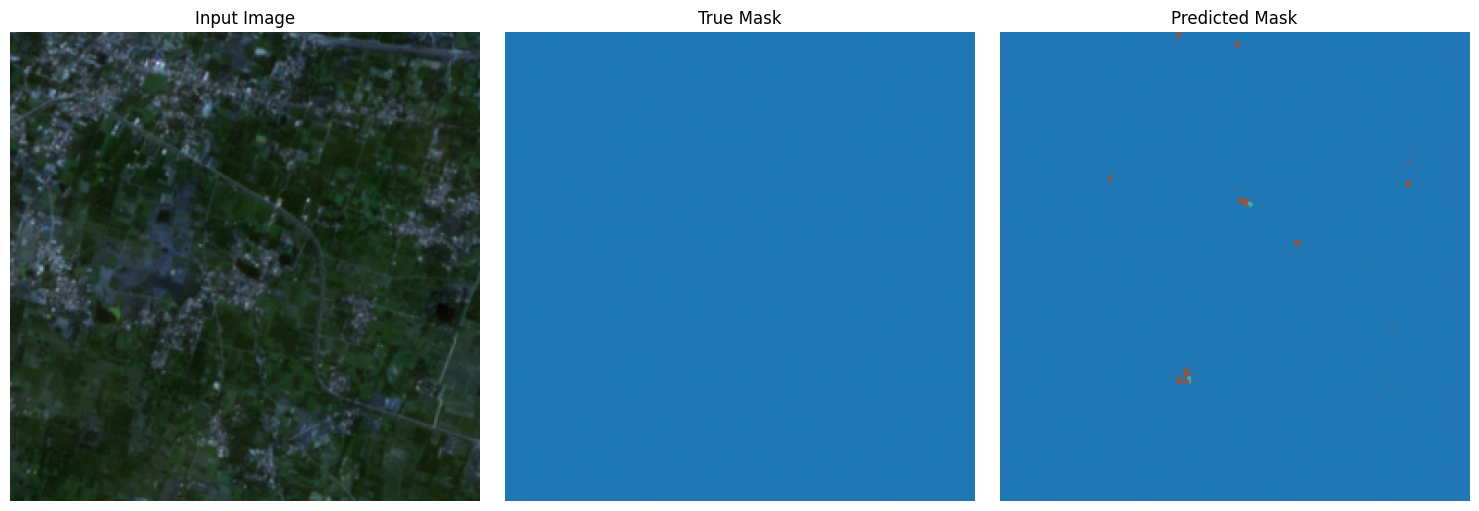


TESTING ON ALL CROP TILES

Processing: rasterlayer_09_37.tif
  Accuracy: 99.81%
  Wheat: predicted=111, true=0
  Mustard: predicted=12, true=0

Processing: rasterlayer_09_38.tif
  Accuracy: 99.84%
  Wheat: predicted=102, true=0
  Mustard: predicted=1, true=0

Processing: rasterlayer_10_37.tif
  Accuracy: 99.40%
  Wheat: predicted=389, true=0
  Mustard: predicted=4, true=0

Processing: rasterlayer_10_38.tif
  Accuracy: 99.65%
  Wheat: predicted=71, true=112
  Mustard: predicted=0, true=46

Processing: rasterlayer_11_37.tif
  Accuracy: 99.14%
  Wheat: predicted=1003, true=953
  Mustard: predicted=205, true=218

Processing: rasterlayer_11_38.tif
  Accuracy: 99.24%
  Wheat: predicted=420, true=0
  Mustard: predicted=76, true=0

Processing: rasterlayer_12_37.tif
  Accuracy: 99.36%
  Wheat: predicted=409, true=0
  Mustard: predicted=11, true=0

Processing: rasterlayer_12_38.tif
  Accuracy: 99.13%
  Wheat: predicted=537, true=0
  Mustard: predicted=34, true=0

SUMMARY
Average Accuracy: 99.45

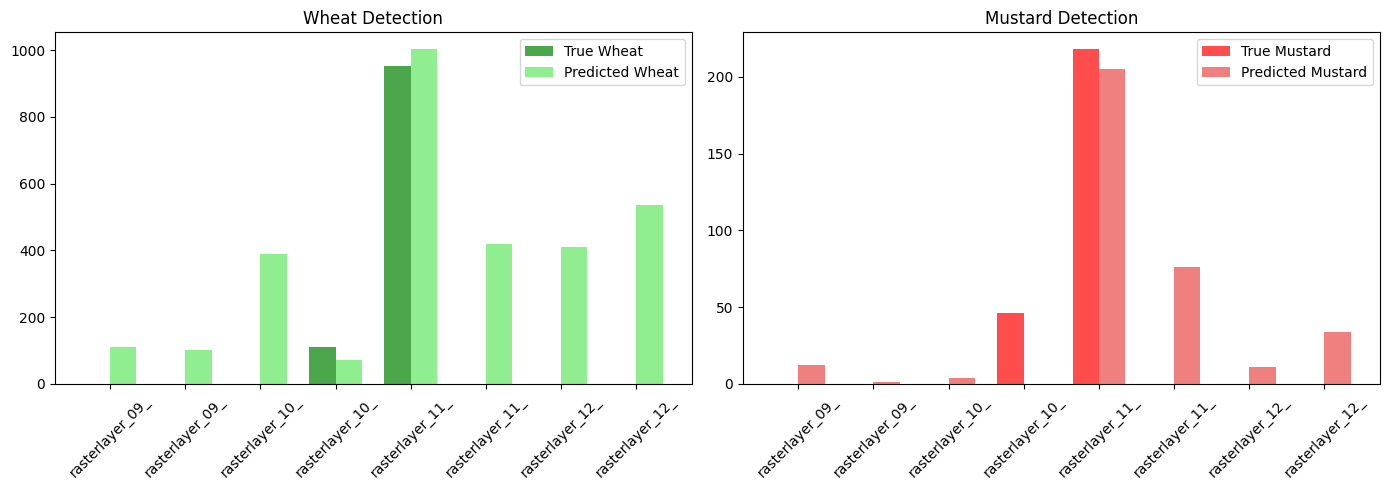

In [ ]:


def predict_full_tile(tile_path, seg_model, patch_size=64, stride=32):

    with rasterio.open(tile_path) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    h, w = img.shape[:2]
    full_pred = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.int32)

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patch_batch = np.expand_dims(patch, 0)

            pred = seg_model.predict(patch_batch, verbose=0)[0]
            pred_classes = np.argmax(pred, axis=-1).astype(np.float32)

            full_pred[y:y+patch_size, x:x+patch_size] += pred_classes
            counts[y:y+patch_size, x:x+patch_size] += 1


    full_pred = np.divide(full_pred, np.maximum(counts, 1), where=counts>0)
    full_pred = np.round(full_pred).astype(np.uint8)

    return full_pred

test_tile = crop_tiles[0]
tile_path = os.path.join(image_folder, test_tile)
mask_f = test_tile.replace('.tif', '_mask.tif')
mask_path = os.path.join(mask_folder, mask_f)

print(f"\nTesting on: {test_tile}")


prediction = predict_full_tile(tile_path, seg_model)


with rasterio.open(mask_path) as src:
    true_mask = src.read(1)


correct = np.sum(prediction == true_mask)
total = true_mask.size
acc = correct / total * 100


print(f"  Accuracy: {acc:.2f}%")
print(f"  Background: {np.sum(prediction == 0)} pixels")
print(f"  Wheat: {np.sum(prediction == 1)} pixels")
print(f"  Mustard: {np.sum(prediction == 2)} pixels")


fig, axes = plt.subplots(1, 3, figsize=(15, 5))


with rasterio.open(tile_path) as src:
    img = src.read()
    img = np.transpose(img, (1, 2, 0))[:,:,:3]
    img = (img - img.min()) / (img.max() - img.min())

axes[0].imshow(img)
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(true_mask, cmap='tab10', vmin=0, vmax=2)
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(prediction, cmap='tab10', vmin=0, vmax=2)
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()



results = []
for tile_f in crop_tiles:


    tile_path = os.path.join(image_folder, tile_f)
    mask_f = tile_f.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_folder, mask_f)


    pred = predict_full_tile(tile_path, seg_model)


    with rasterio.open(mask_path) as src:
        true = src.read(1)


    correct = np.sum(pred == true)
    total = true.size
    acc = correct / total * 100

    wheat_pred = np.sum(pred == 1)
    mustard_pred = np.sum(pred == 2)
    wheat_true = np.sum(true == 1)
    mustard_true = np.sum(true == 2)

    results.append({
        'tile': tile_f,
        'accuracy': acc,
        'wheat_pred': wheat_pred,
        'mustard_pred': mustard_pred,
        'wheat_true': wheat_true,
        'mustard_true': mustard_true
    })

    print(f"  Accuracy: {acc:.2f}%")
    print(f"  Wheat: predicted={wheat_pred}, true={wheat_true}")
    print(f"  Mustard: predicted={mustard_pred}, true={mustard_true}")



avg_acc = np.mean([r['accuracy'] for r in results])
print(f"Average Accuracy: {avg_acc:.2f}%")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

tiles = [r['tile'][:15] for r in results]
wheat_true = [r['wheat_true'] for r in results]
wheat_pred = [r['wheat_pred'] for r in results]
mustard_true = [r['mustard_true'] for r in results]
mustard_pred = [r['mustard_pred'] for r in results]

x = np.arange(len(tiles))
width = 0.35

axes[0].bar(x - width/2, wheat_true, width, label='True Wheat', color='green', alpha=0.7)
axes[0].bar(x + width/2, wheat_pred, width, label='Predicted Wheat', color='lightgreen')
axes[0].set_title('Wheat Detection')
axes[0].set_xticks(x)
axes[0].set_xticklabels(tiles, rotation=45)
axes[0].legend()

axes[1].bar(x - width/2, mustard_true, width, label='True Mustard', color='red', alpha=0.7)
axes[1].bar(x + width/2, mustard_pred, width, label='Predicted Mustard', color='lightcoral')
axes[1].set_title('Mustard Detection')
axes[1].set_xticks(x)
axes[1].set_xticklabels(tiles, rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

🎯 TWO-STAGE MODEL FOR 2 TILES

Loading rasterlayer_10_38.tif...
  Wheat: 112 pixels
  Mustard: 46 pixels
  Background: 65378 pixels

Loading rasterlayer_11_37.tif...
  Wheat: 953 pixels
  Mustard: 218 pixels
  Background: 64365 pixels

✅ Loaded 2 tiles
X shape: (2, 256, 256, 4)
y shape: (2, 256, 256)

STAGE 1: TRAINING CROP DETECTOR

STAGE 2: TRAINING SEGMENTATION MODEL
Tile 1: extracted 0 crop patches
Tile 2: extracted 300 crop patches

📦 Total patches: 300
Patches shape: (300, 64, 64, 4)
Patches mask shape: (300, 64, 64)

Class distribution in patches:
  Class 0: 966350 pixels (78.64%)
  Class 1: 217176 pixels (17.67%)
  Class 2: 45274 pixels (3.68%)

Training patches: 240
Validation patches: 60


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      1,184 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_7[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_11[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ conv2d_12[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64,    │          0 │ conv2d_14[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 96)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_15[0][0] 

 Total params: 471,907 (1.80 MB)

 Trainable params: 471,907 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5454 - loss: 0.9973 - val_accuracy: 0.7908 - val_loss: 0.8007
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7849 - loss: 0.7547 - val_accuracy: 0.7908 - val_loss: 0.6452
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7852 - loss: 0.6501 - val_accuracy: 0.7908 - val_loss: 0.6165
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7878 - loss: 0.6059 - val_accuracy: 0.7908 - val_loss: 0.5566
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7856 - loss: 0.5636 - val_accuracy: 0.7908 - val_loss: 0.5623
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7805 - loss: 0.5572 - val_accuracy: 0.7908 - val_loss: 0.5396
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7848 - loss: 0.5342 - val_accuracy: 0.7908 - val_loss: 0.5137
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7871 - loss: 0.5089 - val_accuracy: 0.7908 - val_loss: 0.4958
E

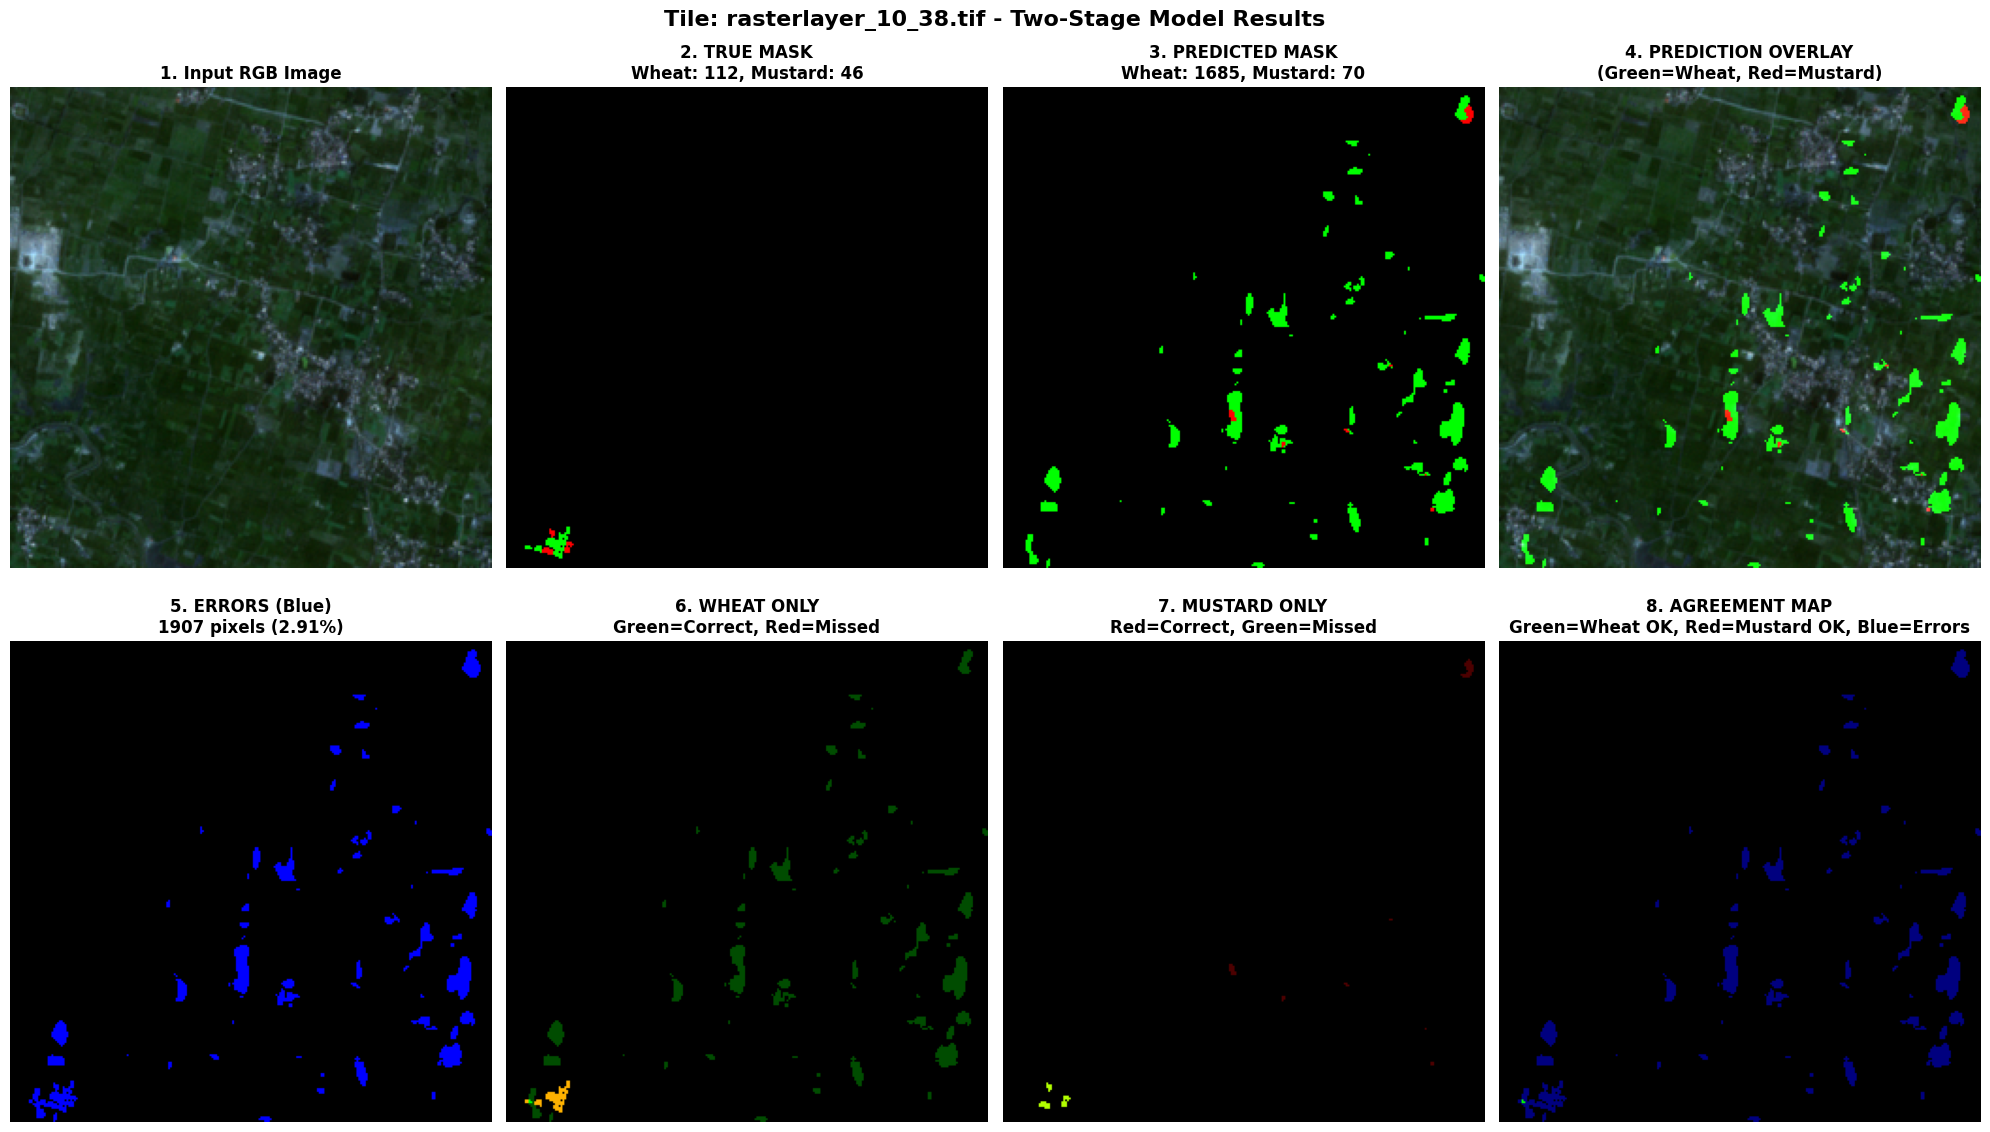

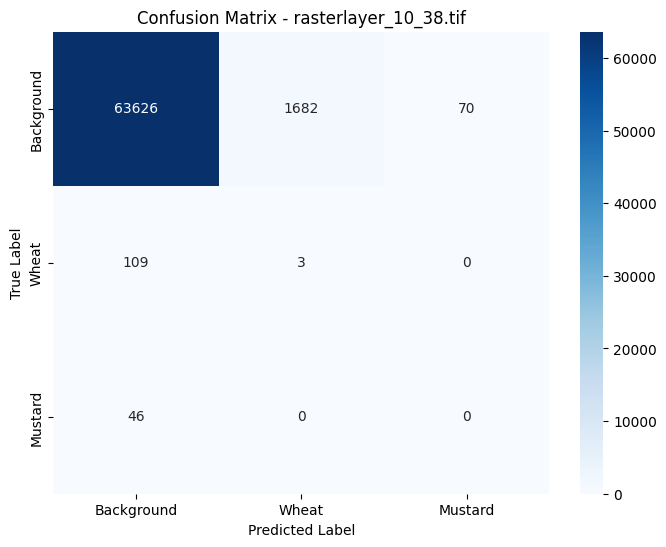


📊 CLASSIFICATION REPORT - rasterlayer_10_38.tif
              precision    recall  f1-score   support

  Background       1.00      0.97      0.99     65378
       Wheat       0.00      0.03      0.00       112
     Mustard       0.00      0.00      0.00        46

    accuracy                           0.97     65536
   macro avg       0.33      0.33      0.33     65536
weighted avg       1.00      0.97      0.98     65536


📌 TILE: rasterlayer_11_37.tif
🌾 WHEAT:
   True:  953 pixels
   Pred: 2737 pixels
   Diff: 1784 pixels

🌿 MUSTARD:
   True:  218 pixels
   Pred:  149 pixels
   Diff:  -69 pixels


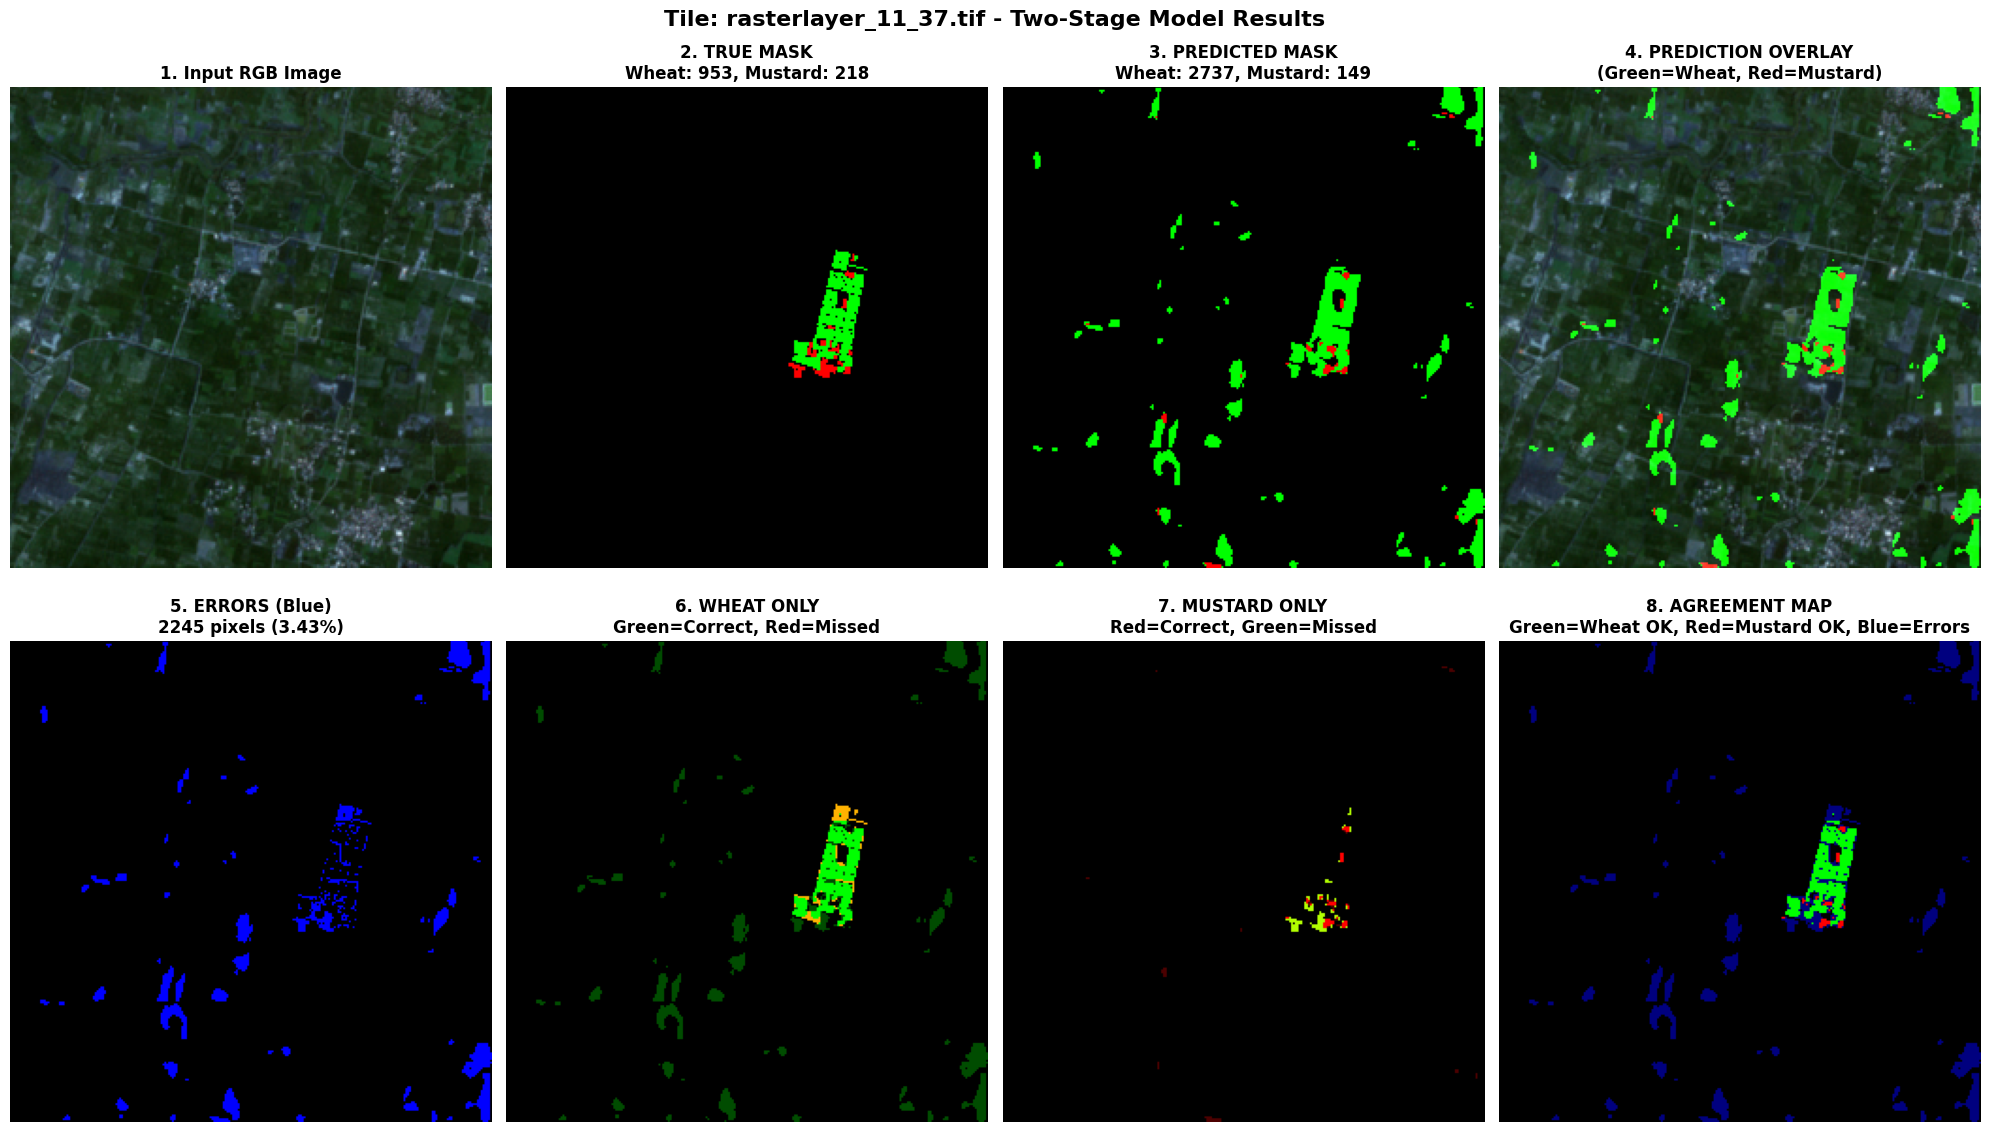

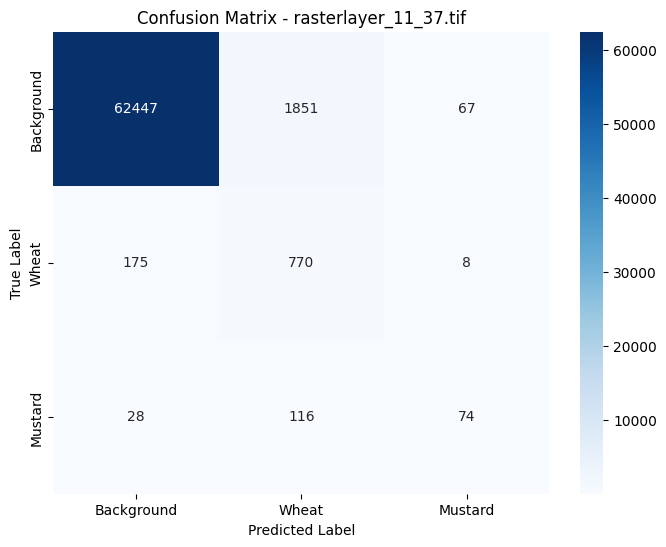


📊 CLASSIFICATION REPORT - rasterlayer_11_37.tif
              precision    recall  f1-score   support

  Background       1.00      0.97      0.98     64365
       Wheat       0.28      0.81      0.42       953
     Mustard       0.50      0.34      0.40       218

    accuracy                           0.97     65536
   macro avg       0.59      0.71      0.60     65536
weighted avg       0.98      0.97      0.97     65536


✅ Two-stage model saved!


In [ ]:

focus_tiles = [
    'rasterlayer_10_38.tif',  # Has 112 wheat, 46 mustard
    'rasterlayer_11_37.tif'   # Has 953 wheat, 218 mustard
]



X = []
y = []
tile_names = []

for tile_f in focus_tiles:


    with rasterio.open(os.path.join(image_folder, tile_f)) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))


    mask_f = tile_f.replace('.tif', '_mask.tif')
    with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
        mask = src.read(1)

    X.append(img)
    y.append(mask)
    tile_names.append(tile_f)


    wheat = np.sum(mask == 1)
    mustard = np.sum(mask == 2)
    print(f"  Wheat: {wheat} pixels")
    print(f"  Mustard: {mustard} pixels")
    print(f"  Background: {np.sum(mask == 0)} pixels")

X = np.array(X)
y = np.array(y)


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")




y_detector = np.array([1, 1])

def extract_crop_patches(image, mask, patch_size=64, max_patches=200):

    patches_X = []
    patches_y = []
    h, w = image.shape[:2]

    crop_y, crop_x = np.where(mask > 0)

    if len(crop_y) == 0:
        return np.array([]), np.array([])

    n_patches = min(max_patches, len(crop_y) * 2)
    indices = np.random.choice(len(crop_y), n_patches, replace=True)

    for idx in indices:
        cy, cx = crop_y[idx], crop_x[idx]


        y1 = max(0, cy - patch_size//2 + np.random.randint(-10, 10))
        x1 = max(0, cx - patch_size//2 + np.random.randint(-10, 10))
        y2 = min(h, y1 + patch_size)
        x2 = min(w, x1 + patch_size)

        if y2 - y1 == patch_size and x2 - x1 == patch_size:
            patch_img = image[y1:y2, x1:x2]
            patch_mask = mask[y1:y2, x1:x2]
            patches_X.append(patch_img)
            patches_y.append(patch_mask)

    return np.array(patches_X), np.array(patches_y)

X_patches = []
y_patches = []

for i in range(len(X)):
    pX, py = extract_crop_patches(X[i], y[i], patch_size=64, max_patches=300)
    X_patches.extend(pX)
    y_patches.extend(py)
    print(f"Tile {i+1}: extracted {len(pX)} crop patches")

X_patches = np.array(X_patches)
y_patches = np.array(y_patches)

print(f"\nTotal patches: {len(X_patches)}")
print(f"Patches shape: {X_patches.shape}")
print(f"Patches mask shape: {y_patches.shape}")

unique, counts = np.unique(y_patches, return_counts=True)
print("\nClass distribution in patches:")
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} pixels ({c/np.prod(y_patches.shape)*100:.2f}%)")


X_train, X_val, y_train, y_val = train_test_split(
    X_patches, y_patches, test_size=0.2, random_state=42
)

print(f"\nTraining patches: {X_train.shape[0]}")
print(f"Validation patches: {X_val.shape[0]}")



def create_segmentation_model(input_shape=(64, 64, 4), num_classes=3):
    #U-Net for patch segmentation
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(2)(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(2)(conv2)

    # Bridge
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = layers.UpSampling2D(2)(conv3)
    up4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(2)(conv4)
    up5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


model = create_segmentation_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    verbose=1
)


def predict_full_tile(model, tile_path, patch_size=64, stride=32):

    with rasterio.open(tile_path) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    h, w = img.shape[:2]
    full_pred = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.int32)

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patch_batch = np.expand_dims(patch, 0)

            pred = model.predict(patch_batch, verbose=0)[0]
            pred_classes = np.argmax(pred, axis=-1).astype(np.float32)

            full_pred[y:y+patch_size, x:x+patch_size] += pred_classes
            counts[y:y+patch_size, x:x+patch_size] += 1

    full_pred = np.divide(full_pred, np.maximum(counts, 1))
    return np.round(full_pred).astype(np.uint8)



for i, tile_f in enumerate(focus_tiles):
    tile_path = os.path.join(image_folder, tile_f)
    mask_f = tile_f.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_folder, mask_f)

    pred = predict_full_tile(model, tile_path)


    with rasterio.open(mask_path) as src:
        true = src.read(1)


    wheat_true = np.sum(true == 1)
    wheat_pred = np.sum(pred == 1)
    mustard_true = np.sum(true == 2)
    mustard_pred = np.sum(pred == 2)

    print(f"\n{'='*60}")
    print(f"TILE: {tile_f}")
    print(f"{'='*60}")
    print(f" WHEAT:")
    print(f"   True: {wheat_true:4d} pixels")
    print(f"   Pred: {wheat_pred:4d} pixels")
    print(f"   Diff: {wheat_pred - wheat_true:4d} pixels")
    print(f"\n MUSTARD:")
    print(f"   True: {mustard_true:4d} pixels")
    print(f"   Pred: {mustard_pred:4d} pixels")
    print(f"   Diff: {mustard_pred - mustard_true:4d} pixels")



    fig = plt.figure(figsize=(20, 12))


    with rasterio.open(tile_path) as src:
        img_rgb = src.read()
        img_rgb = np.transpose(img_rgb, (1, 2, 0))[:,:,:3]
        img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())

    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(img_rgb)
    ax1.set_title('1. Input RGB Image', fontsize=12, fontweight='bold')
    ax1.axis('off')

    ax2 = plt.subplot(2, 4, 2)
    true_disp = np.zeros((*true.shape, 3))
    true_disp[..., 1] = (true == 1) * 1.0  # Green for wheat
    true_disp[..., 0] = (true == 2) * 1.0  # Red for mustard
    ax2.imshow(true_disp)
    ax2.set_title(f'2. TRUE MASK\nWheat: {wheat_true}, Mustard: {mustard_true}',
                  fontsize=12, fontweight='bold')
    ax2.axis('off')



    ax3 = plt.subplot(2, 4, 3)
    pred_disp = np.zeros((*pred.shape, 3))
    pred_disp[..., 1] = (pred == 1) * 1.0  # Green for wheat
    pred_disp[..., 0] = (pred == 2) * 1.0  # Red for mustard
    ax3.imshow(pred_disp)
    ax3.set_title(f'3. PREDICTED MASK\nWheat: {wheat_pred}, Mustard: {mustard_pred}',
                  fontsize=12, fontweight='bold')
    ax3.axis('off')



    ax4 = plt.subplot(2, 4, 4)
    overlay = img_rgb.copy()
    overlay[..., 0] = np.where(pred == 2, 1.0, overlay[..., 0])  # Red overlay for mustard
    overlay[..., 1] = np.where(pred == 1, 1.0, overlay[..., 1])  # Green overlay for wheat
    ax4.imshow(overlay)
    ax4.set_title('4. PREDICTION OVERLAY\n(Green=Wheat, Red=Mustard)',
                  fontsize=12, fontweight='bold')
    ax4.axis('off')


    ax5 = plt.subplot(2, 4, 5)
    error = (pred != true)
    error_disp = np.zeros((*error.shape, 3))
    error_disp[..., 2] = error * 1.0  # Blue for errors
    ax5.imshow(error_disp)
    error_pixels = np.sum(error)
    error_pct = error_pixels / true.size * 100
    ax5.set_title(f'5. ERRORS (Blue)\n{error_pixels} pixels ({error_pct:.2f}%)',
                  fontsize=12, fontweight='bold')
    ax5.axis('off')



    ax6 = plt.subplot(2, 4, 6)
    wheat_compare = np.zeros((*true.shape, 3))
    wheat_compare[..., 1] = (true == 1) * 0.7  # Light green for true wheat
    wheat_compare[..., 1] += (pred == 1) * 0.3  # Darker green overlap
    wheat_compare[..., 0] = ((true == 1) & (pred != 1)) * 1.0  # Red for missed wheat
    ax6.imshow(wheat_compare)
    ax6.set_title('6. WHEAT ONLY\nGreen=Correct, Red=Missed',
                  fontsize=12, fontweight='bold')
    ax6.axis('off')


    ax7 = plt.subplot(2, 4, 7)
    mustard_compare = np.zeros((*true.shape, 3))
    mustard_compare[..., 0] = (true == 2) * 0.7  # Light red for true mustard
    mustard_compare[..., 0] += (pred == 2) * 0.3  # Darker red overlap
    mustard_compare[..., 1] = ((true == 2) & (pred != 2)) * 1.0  # Green for missed mustard
    ax7.imshow(mustard_compare)
    ax7.set_title('7. MUSTARD ONLY\nRed=Correct, Green=Missed',
                  fontsize=12, fontweight='bold')
    ax7.axis('off')


    ax8 = plt.subplot(2, 4, 8)
    agreement = np.zeros((*true.shape, 3))
    agreement[..., 1] = ((pred == 1) & (true == 1)) * 1.0  # Green for correct wheat
    agreement[..., 0] = ((pred == 2) & (true == 2)) * 1.0  # Red for correct mustard
    agreement[..., 2] = (pred != true) * 0.5  # Blue for errors
    ax8.imshow(agreement)
    ax8.set_title('8. AGREEMENT MAP\nGreen=Wheat OK, Red=Mustard OK, Blue=Errors',
                  fontsize=12, fontweight='bold')
    ax8.axis('off')

    plt.suptitle(f'Tile: {tile_f} - Two-Stage Model Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()



    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(true.flatten(), pred.flatten(), labels=[0, 1, 2])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Background', 'Wheat', 'Mustard'],
                yticklabels=['Background', 'Wheat', 'Mustard'])
    plt.title(f'Confusion Matrix - {tile_f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


    from sklearn.metrics import classification_report

    print(f"\nCLASSIFICATION REPORT - {tile_f}")

    print(classification_report(true.flatten(), pred.flatten(),
                               target_names=['Background', 'Wheat', 'Mustard']))



model.save('/content/drive/MyDrive/CropMapping/twostage_2tile_model.h5')


🌾 TWO-STAGE WHEAT vs MUSTARD SEGMENTATION
Using 8 tiles with crops

📊 Loading all available tiles...
Total tiles available: 1518
Stage 1 training: 50 tiles (8 with crops, 42 empty)


Loading stage 1 data: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]



Stage 1 data shape: (50, 256, 256, 4)
Class distribution: Counter({np.int64(0): 48, np.int64(1): 2})

STAGE 1: TRAINING CROP DETECTION MODEL
Stage 1 - Training: 40, Validation: 10


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,857 (397.88 KB)

 Trainable params: 101,857 (397.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - accuracy: 0.9399 - loss: 0.6081 - val_accuracy: 1.0000 - val_loss: 0.3969
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9278 - loss: 0.3319 - val_accuracy: 1.0000 - val_loss: 0.1976
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9833 - loss: 0.2360 - val_accuracy: 1.0000 - val_loss: 0.1014
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9590 - loss: 0.3322 - val_accuracy: 1.0000 - val_loss: 0.1160
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9781 - loss: 0.1600 - val_accuracy: 1.0000 - val_loss: 0.1328
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9660 - loss: 0.1967 - val_accuracy: 1.0000 - val_loss: 0.1574
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9729 - loss: 0.1813 - val_accuracy: 1.0000 - val_loss: 0.1331
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9729 - loss: 0.1638 - val_accuracy: 1.0000 - val_loss: 0.0811

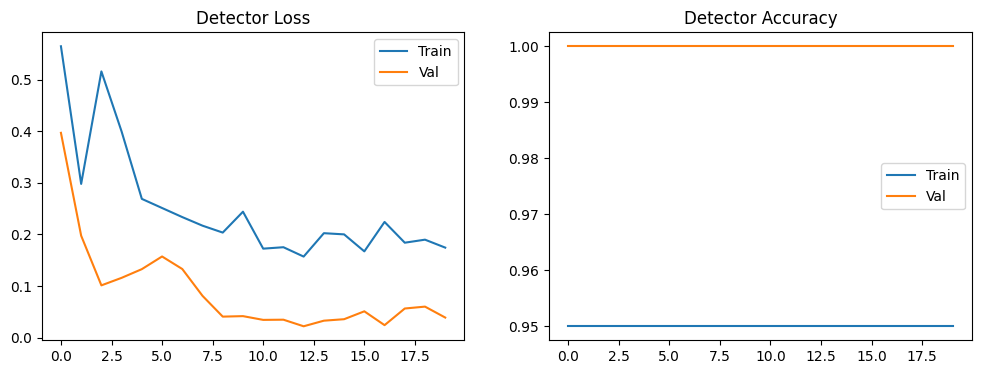


STAGE 2: PREPARING SEGMENTATION DATA


Loading crop tiles: 100%|██████████| 8/8 [00:00<00:00, 16.82it/s]


Stage 2 data shape: (8, 256, 256, 4)
Stage 2 masks shape: (8, 256, 256)

📦 Creating balanced patches...
Created 300 patches of size 64x64
Patches shape: (300, 64, 64, 4)
Patches mask shape: (300, 64, 64)

Class distribution in patches:
  Class 0: 1127936 pixels (91.79%)
  Class 1: 84017 pixels (6.84%)
  Class 2: 16847 pixels (1.37%)

Patches - Training: 240, Validation: 60

STAGE 2: BUILDING SEGMENTATION MODEL


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      1,184 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_21[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 192)              │            │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_27[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 96)               │            │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │     27,680 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_29[0][0] 

 Total params: 471,907 (1.80 MB)

 Trainable params: 471,907 (1.80 MB)

 Non-trainable params: 0 (0.00 B)


Class weights: {np.uint8(0): np.float64(0.3651636873419654), np.uint8(1): np.float64(4.567477906944328), np.uint8(2): np.float64(23.494658349465833)}

🚀 Training segmentation model on patches...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4195 - loss: 1.0413

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 649ms/step - accuracy: 0.4453 - loss: 1.0478 - val_accuracy: 0.9383 - val_loss: 1.0716 - learning_rate: 0.0010
Epoch 2/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8230 - loss: 1.0623

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8164 - loss: 1.0694 - val_accuracy: 0.6540 - val_loss: 1.0681 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6067 - loss: 1.0155 - val_accuracy: 0.2014 - val_loss: 1.1362 - learning_rate: 0.0010
Epoch 4/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3313 - loss: 1.0206

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3426 - loss: 1.0155 - val_accuracy: 0.5809 - val_loss: 0.7763 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5116 - loss: 0.9354 - val_accuracy: 0.2474 - val_loss: 1.2982 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3867 - loss: 0.9336 - val_accuracy: 0.4782 - val_loss: 0.8807 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4881 - loss: 0.8360 - val_accuracy: 0.1727 - val_loss: 1.5068 - learning_rate: 0.0010
Epoch 8/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3048 - loss: 0.9428

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3434 - loss: 0.9339 - val_accuracy: 0.7215 - val_loss: 0.6284 - learning_rate: 0.0010
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6125 - loss: 0.8325 - val_accuracy: 0.4354 - val_loss: 0.9442 - learning_rate: 0.0010
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4053 - loss: 0.7936 - val_accuracy: 0.4514 - val_loss: 0.8564 - learning_rate: 0.0010
Epoch 11/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4378 - loss: 0.7764

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4561 - loss: 0.7671 - val_accuracy: 0.7542 - val_loss: 0.5191 - learning_rate: 0.0010
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6458 - loss: 0.6156 - val_accuracy: 0.7603 - val_loss: 0.5329 - learning_rate: 0.0010
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7239 - loss: 0.5602 - val_accuracy: 0.6188 - val_loss: 0.8091 - learning_rate: 0.0010
Epoch 14/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7170 - loss: 0.5428

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7247 - loss: 0.5395 - val_accuracy: 0.8147 - val_loss: 0.4804 - learning_rate: 0.0010
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8060 - loss: 0.4626 - val_accuracy: 0.7686 - val_loss: 0.5785 - learning_rate: 0.0010
Epoch 16/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8209 - loss: 0.3779

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8261 - loss: 0.3815 - val_accuracy: 0.8494 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 17/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8322 - loss: 0.3935

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8385 - loss: 0.3839 - val_accuracy: 0.8869 - val_loss: 0.3096 - learning_rate: 0.0010
Epoch 18/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8982 - loss: 0.3097

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9007 - loss: 0.3026 - val_accuracy: 0.9017 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 19/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9233 - loss: 0.2324

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9232 - loss: 0.2350 - val_accuracy: 0.9264 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 20/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9253 - loss: 0.2385

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9272 - loss: 0.2324 - val_accuracy: 0.9430 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 21/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9338 - loss: 0.2154

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9352 - loss: 0.2102 - val_accuracy: 0.9503 - val_loss: 0.1555 - learning_rate: 0.0010
Epoch 22/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9505 - loss: 0.1711 - val_accuracy: 0.8709 - val_loss: 0.3750 - learning_rate: 0.0010
Epoch 23/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9101 - loss: 0.2255 - val_accuracy: 0.9097 - val_loss: 0.2621 - learning_rate: 0.0010
Epoch 24/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9293 - loss: 0.1900 - val_accuracy: 0.9390 - val_loss: 0.1734 - learning_rate: 0.0010
Epoch 25/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9496 - loss: 0.1521

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9500 - loss: 0.1524 - val_accuracy: 0.9603 - val_loss: 0.1306 - learning_rate: 0.0010
Epoch 26/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9584 - loss: 0.1378

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9585 - loss: 0.1367 - val_accuracy: 0.9656 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 27/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9595 - loss: 0.1317

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9603 - loss: 0.1288 - val_accuracy: 0.9680 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 28/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9664 - loss: 0.1094

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9665 - loss: 0.1090 - val_accuracy: 0.9684 - val_loss: 0.1029 - learning_rate: 0.0010
Epoch 29/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9631 - loss: 0.1111

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9640 - loss: 0.1082 - val_accuracy: 0.9707 - val_loss: 0.0919 - learning_rate: 0.0010
Epoch 30/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9710 - loss: 0.0870

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9709 - loss: 0.0871 - val_accuracy: 0.9779 - val_loss: 0.0759 - learning_rate: 0.0010
Epoch 31/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9722 - loss: 0.0821 - val_accuracy: 0.9752 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 32/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9734 - loss: 0.0768 - val_accuracy: 0.9716 - val_loss: 0.0963 - learning_rate: 0.0010
Epoch 33/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9735 - loss: 0.0711 - val_accuracy: 0.9745 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 34/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9736 - loss: 0.0660

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9736 - loss: 0.0665 - val_accuracy: 0.9775 - val_loss: 0.0750 - learning_rate: 0.0010
Epoch 35/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9744 - loss: 0.0681 - val_accuracy: 0.9757 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 36/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9760 - loss: 0.0630 - val_accuracy: 0.9748 - val_loss: 0.0839 - learning_rate: 0.0010
Epoch 37/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9759 - loss: 0.0613 - val_accuracy: 0.9773 - val_loss: 0.0780 - learning_rate: 0.0010
Epoch 38/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9775 - loss: 0.0547

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9775 - loss: 0.0547 - val_accuracy: 0.9800 - val_loss: 0.0726 - learning_rate: 0.0010
Epoch 39/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9813 - loss: 0.0473

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9807 - loss: 0.0481 - val_accuracy: 0.9805 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 40/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9795 - loss: 0.0492 - val_accuracy: 0.9781 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 41/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9770 - loss: 0.0545 - val_accuracy: 0.9772 - val_loss: 0.0847 - learning_rate: 0.0010
Epoch 42/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9761 - loss: 0.0558 - val_accuracy: 0.9777 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 43/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9756 - loss: 0.0551

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9760 - loss: 0.0541 - val_accuracy: 0.9817 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 44/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9797 - loss: 0.0450 - val_accuracy: 0.9835 - val_loss: 0.0611 - learning_rate: 0.0010
Epoch 45/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9815 - loss: 0.0453

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9814 - loss: 0.0455 - val_accuracy: 0.9850 - val_loss: 0.0544 - learning_rate: 0.0010
Epoch 46/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9785 - loss: 0.0483 - val_accuracy: 0.9854 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 47/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9776 - loss: 0.0536 - val_accuracy: 0.9809 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 48/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9788 - loss: 0.0443 - val_accuracy: 0.9834 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 49/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9825 - loss: 0.0364 - val_accuracy: 0.9797 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 50/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9834 - loss: 0.0331

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9833 - loss: 0.0335 - val_accuracy: 0.9864 - val_loss: 0.0497 - learning_rate: 0.0010


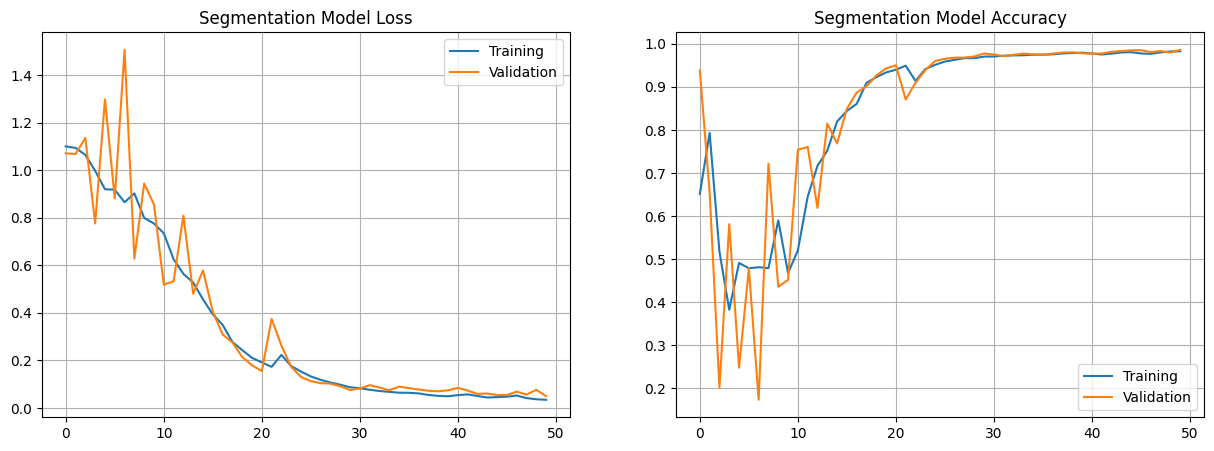


TESTING ON FULL TILES

📊 Testing on: rasterlayer_09_37.tif

📊 Results for rasterlayer_09_37.tif:
  Accuracy: 99.74%
  Background: 65365 pixels
  Wheat: 161 pixels
  Mustard: 10 pixels


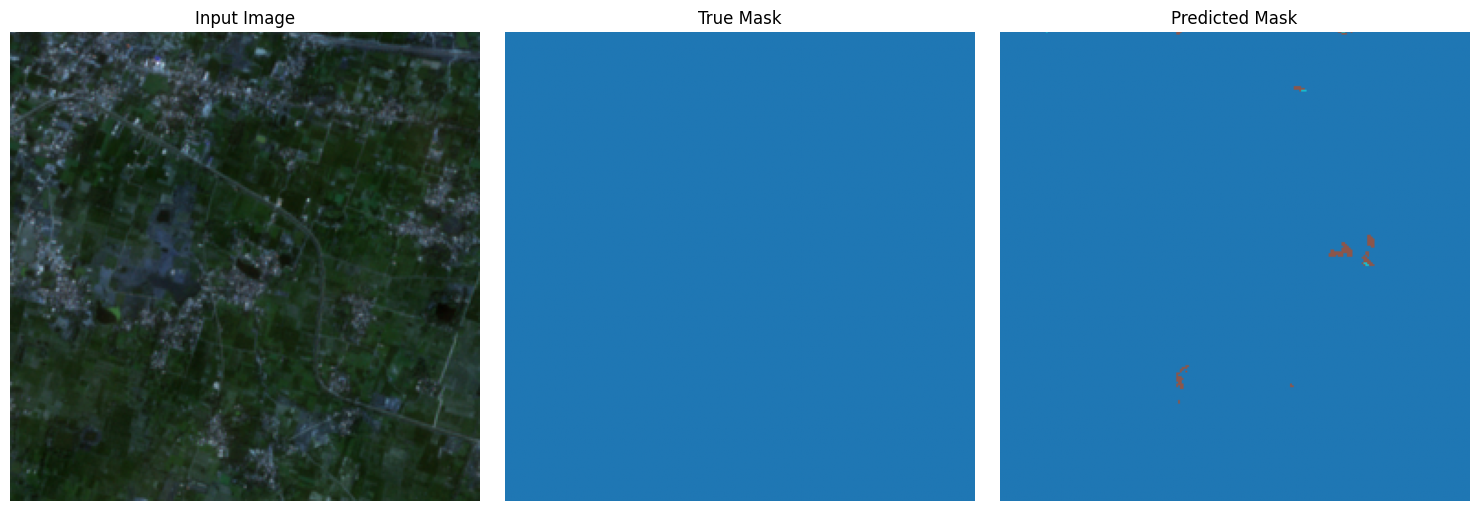


TESTING ON ALL CROP TILES

Processing: rasterlayer_09_37.tif
  Accuracy: 99.74%
  Wheat: predicted=161, true=0
  Mustard: predicted=10, true=0

Processing: rasterlayer_09_38.tif
  Accuracy: 99.91%
  Wheat: predicted=57, true=0
  Mustard: predicted=2, true=0

Processing: rasterlayer_10_37.tif
  Accuracy: 99.82%
  Wheat: predicted=121, true=0
  Mustard: predicted=0, true=0

Processing: rasterlayer_10_38.tif
  Accuracy: 99.69%
  Wheat: predicted=41, true=112
  Mustard: predicted=7, true=46

Processing: rasterlayer_11_37.tif
  Accuracy: 99.13%
  Wheat: predicted=983, true=953
  Mustard: predicted=205, true=218

Processing: rasterlayer_11_38.tif
  Accuracy: 99.56%
  Wheat: predicted=229, true=0
  Mustard: predicted=61, true=0

Processing: rasterlayer_12_37.tif
  Accuracy: 99.80%
  Wheat: predicted=129, true=0
  Mustard: predicted=5, true=0

Processing: rasterlayer_12_38.tif
  Accuracy: 99.68%
  Wheat: predicted=194, true=0
  Mustard: predicted=16, true=0

SUMMARY
Average Accuracy: 99.67%


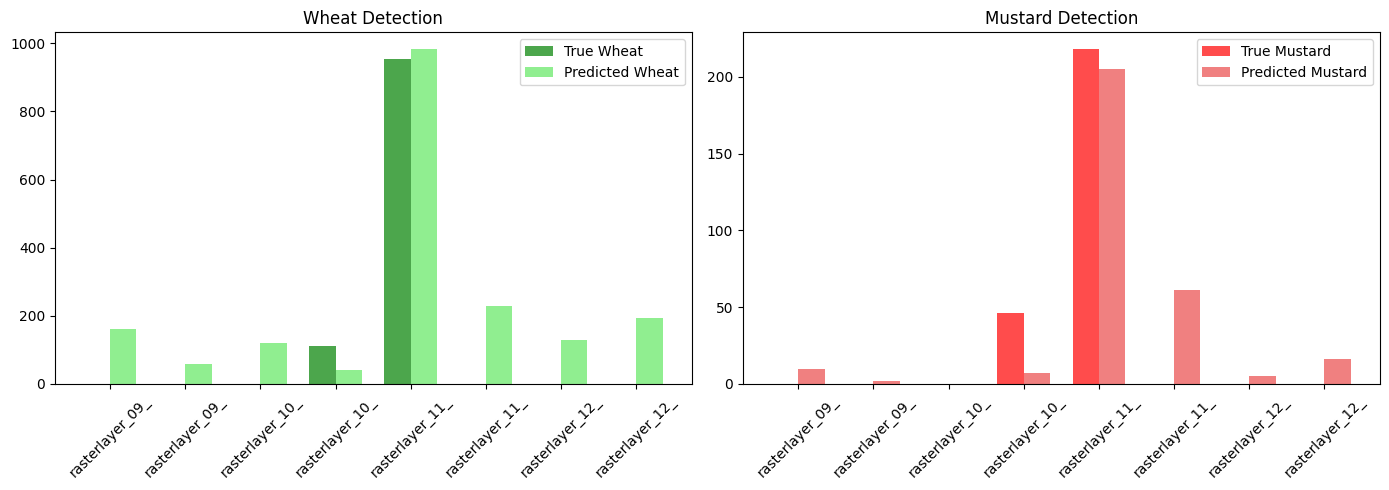


✅ Both models saved to Google Drive!


In [ ]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
import random
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

image_folder = '/content/drive/MyDrive/Colab Notebooks/tiles_256/'
mask_folder = '/content/drive/MyDrive/Colab Notebooks/masks_256/'

crop_tiles = [
    'rasterlayer_09_37.tif',
    'rasterlayer_09_38.tif',
    'rasterlayer_10_37.tif',
    'rasterlayer_10_38.tif',
    'rasterlayer_11_37.tif',
    'rasterlayer_11_38.tif',
    'rasterlayer_12_37.tif',
    'rasterlayer_12_38.tif'
]

print(f"Using {len(crop_tiles)} tiles with crops")

# Load all available tiles
all_tile_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
print(f"Total tiles available: {len(all_tile_files)}")

# Select subset for stage 1 (8 crop tiles + 42 empty tiles)
empty_tiles = [f for f in all_tile_files if f not in crop_tiles]
random.seed(42)
selected_empty = random.sample(empty_tiles, min(42, len(empty_tiles)))

stage1_tiles = crop_tiles + selected_empty
print(f"Stage 1 training: {len(stage1_tiles)} tiles ({len(crop_tiles)} with crops, {len(selected_empty)} empty)")

X_stage1 = []
y_stage1_labels = []

for tile_f in tqdm(stage1_tiles, desc="Loading stage 1 data"):
    with rasterio.open(os.path.join(image_folder, tile_f)) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))
        X_stage1.append(img)

    mask_f = tile_f.replace('.tif', '_mask.tif')
    if os.path.exists(os.path.join(mask_folder, mask_f)):
        with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
            mask = src.read(1)
            has_crops = 1 if np.any(mask > 0) else 0
    else:
        has_crops = 0

    y_stage1_labels.append(has_crops)

X_stage1 = np.array(X_stage1, dtype=np.float32)
y_stage1_labels = np.array(y_stage1_labels)

print(f"Stage 1 data shape: {X_stage1.shape}")
print(f"Class distribution: {Counter(y_stage1_labels)}")

# Stage 1: Crop Detection Model
def create_crop_detector(input_shape=(256, 256, 4)):
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=inputs, outputs=outputs)

X1_train, X1_val, y1_train, y1_val = train_test_split(
    X_stage1, y_stage1_labels, test_size=0.2, random_state=42, stratify=y_stage1_labels
)

detector = create_crop_detector()
detector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_detector = detector.fit(
    X1_train, y1_train,
    validation_data=(X1_val, y1_val),
    batch_size=8,
    epochs=20,
    verbose=1
)

# Plot training results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_detector.history['loss'], label='Train')
plt.plot(history_detector.history['val_loss'], label='Val')
plt.title('Detector Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_detector.history['accuracy'], label='Train')
plt.plot(history_detector.history['val_accuracy'], label='Val')
plt.title('Detector Accuracy')
plt.legend()
plt.show()

# Stage 2: Segmentation Data Preparation
X_seg = []
y_seg = []

for tile_f in tqdm(crop_tiles, desc="Loading crop tiles"):
    with rasterio.open(os.path.join(image_folder, tile_f)) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    mask_f = tile_f.replace('.tif', '_mask.tif')
    with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
        mask = src.read(1)

    X_seg.append(img)
    y_seg.append(mask)

X_seg = np.array(X_seg, dtype=np.float32)
y_seg = np.array(y_seg, dtype=np.uint8)

def create_balanced_patches(image, mask, patch_size=64, num_patches=100):
    patches_X, patches_y = [], []
    h, w = image.shape[:2]
    crop_y, crop_x = np.where(mask > 0)

    if len(crop_y) == 0:
        return np.array([]), np.array([])

    for _ in range(num_patches // 2):
        idx = random.randint(0, len(crop_y)-1)
        cy, cx = crop_y[idx], crop_x[idx]
        y1, x1 = max(0, cy - patch_size//2), max(0, cx - patch_size//2)
        y2, x2 = min(h, y1 + patch_size), min(w, x1 + patch_size)
        if y2 - y1 == patch_size and x2 - x1 == patch_size:
            patches_X.append(image[y1:y2, x1:x2])
            patches_y.append(mask[y1:y2, x1:x2])

    for _ in range(num_patches // 2):
        y1, x1 = random.randint(0, h - patch_size), random.randint(0, w - patch_size)
        patches_X.append(image[y1:y1+patch_size, x1:x1+patch_size])
        patches_y.append(mask[y1:y1+patch_size, x1:x1+patch_size])

    return np.array(patches_X), np.array(patches_y)

X_patches, y_patches = [], []
for i in range(len(X_seg)):
    pX, py = create_balanced_patches(X_seg[i], y_seg[i], patch_size=64, num_patches=200)
    if len(pX) > 0:
        X_patches.extend(pX)
        y_patches.extend(py)

X_patches, y_patches = np.array(X_patches), np.array(y_patches)
Xp_train, Xp_val, yp_train, yp_val = train_test_split(X_patches, y_patches, test_size=0.2, random_state=42)

# Stage 2: Segmentation Model (U-Net)
def create_segmentation_model(input_shape=(64, 64, 4), num_classes=3):
    inputs = layers.Input(input_shape)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(2)(conv1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(2)(conv2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    up4 = layers.UpSampling2D(2)(conv3)
    up4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)
    up5 = layers.UpSampling2D(2)(conv4)
    up5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv5)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv5)
    return models.Model(inputs=inputs, outputs=outputs)

seg_model = create_segmentation_model()
seg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Class and sample weights
unique, counts = np.unique(yp_train, return_counts=True)
total = np.sum(counts)
class_weight_dict = {i: total / (len(unique) * c) for i, c in zip(unique, counts)}

def create_sample_weights(y, class_weights):
    sample_weights = np.zeros(y.shape, dtype=np.float32)
    for class_idx, weight in class_weights.items():
        sample_weights[y == class_idx] = weight
    return sample_weights

sample_weights_train = create_sample_weights(yp_train, class_weight_dict)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5),
    ModelCheckpoint('best_seg_model.h5', save_best_only=True)
]

history_seg = seg_model.fit(
    Xp_train, yp_train,
    sample_weight=sample_weights_train,
    validation_data=(Xp_val, yp_val),
    batch_size=32,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# Plot segmentation training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_seg.history['loss'], label='Training')
ax1.plot(history_seg.history['val_loss'], label='Validation')
ax1.set_title('Segmentation Model Loss')
ax1.legend()
ax1.grid(True)
ax2.plot(history_seg.history['accuracy'], label='Training')
ax2.plot(history_seg.history['val_accuracy'], label='Validation')
ax2.set_title('Segmentation Model Accuracy')
ax2.legend()
ax2.grid(True)
plt.show()

# Testing on Full Tiles
def predict_full_tile(tile_path, seg_model, patch_size=64, stride=32):
    with rasterio.open(tile_path) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    h, w = img.shape[:2]
    full_pred = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.int32)

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patch_batch = np.expand_dims(patch, 0)
            pred = seg_model.predict(patch_batch, verbose=0)[0]
            pred_classes = np.argmax(pred, axis=-1).astype(np.float32)
            full_pred[y:y+patch_size, x:x+patch_size] += pred_classes
            counts[y:y+patch_size, x:x+patch_size] += 1

    full_pred = np.divide(full_pred, np.maximum(counts, 1), where=counts>0)
    return np.round(full_pred).astype(np.uint8)

# Single tile validation
test_tile = crop_tiles[0]
tile_path = os.path.join(image_folder, test_tile)
mask_path = os.path.join(mask_folder, test_tile.replace('.tif', '_mask.tif'))

prediction = predict_full_tile(tile_path, seg_model)
with rasterio.open(mask_path) as src:
    true_mask = src.read(1)

print(f"Results for {test_tile}:")
print(f"Accuracy: {np.sum(prediction == true_mask) / true_mask.size * 100:.2f}%")

# Results visualization
results = []
for tile_f in crop_tiles:
    pred = predict_full_tile(os.path.join(image_folder, tile_f), seg_model)
    with rasterio.open(os.path.join(mask_folder, tile_f.replace('.tif', '_mask.tif'))) as src:
        true = src.read(1)

    results.append({
        'tile': tile_f,
        'accuracy': np.sum(pred == true) / true.size * 100,
        'wheat_pred': np.sum(pred == 1),
        'mustard_pred': np.sum(pred == 2),
        'wheat_true': np.sum(true == 1),
        'mustard_true': np.sum(true == 2)
    })

detector.save('/content/drive/MyDrive/CropMapping/crop_detector.h5')
seg_model.save('/content/drive/MyDrive/CropMapping/crop_segmentor.h5')


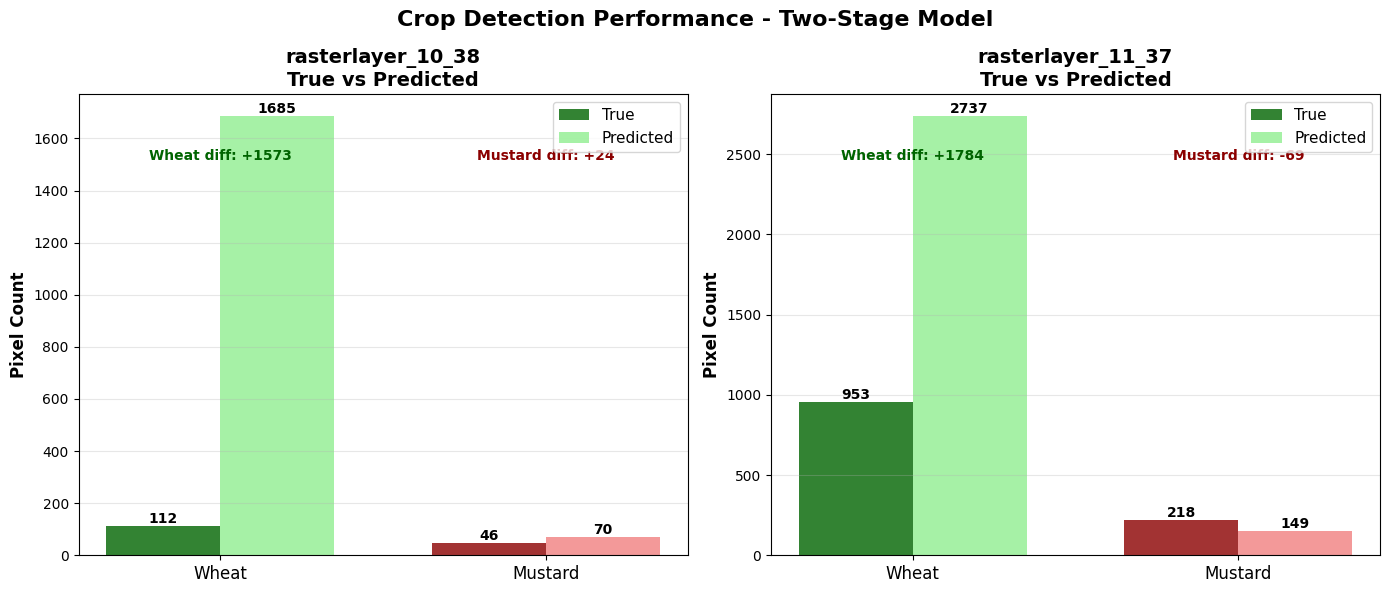


📊 PREDICTION SUMMARY

🌾 WHEAT TOTAL:
   True: 1065 pixels
   Pred: 4422 pixels
   Diff: +3357 pixels
   Accuracy: 415.21%

🌿 MUSTARD TOTAL:
   True: 264 pixels
   Pred: 219 pixels
   Diff: -45 pixels
   Accuracy: 82.95%

📊 WHEAT:MUSTARD RATIO:
   True: 4.03:1
   Pred: 20.19:1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

tiles = ['rasterlayer_10_38', 'rasterlayer_11_37']

data = {
    'rasterlayer_10_38': {
        'wheat_true': 112,
        'wheat_pred': 1685,
        'mustard_true': 46,
        'mustard_pred': 70
    },
    'rasterlayer_11_37': {
        'wheat_true': 953,
        'wheat_pred': 2737,
        'mustard_true': 218,
        'mustard_pred': 149
    }
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, tile in enumerate(tiles):
    ax = axes[idx]

    categories = ['Wheat', 'Mustard']
    true_values = [data[tile]['wheat_true'], data[tile]['mustard_true']]
    pred_values = [data[tile]['wheat_pred'], data[tile]['mustard_pred']]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax.bar(x - width/2, true_values, width, label='True',
                   color=['darkgreen', 'darkred'], alpha=0.8)
    bars2 = ax.bar(x + width/2, pred_values, width, label='Predicted',
                   color=['lightgreen', 'lightcoral'], alpha=0.8)

    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    ax.set_ylabel('Pixel Count', fontsize=12, fontweight='bold')
    ax.set_title(f'{tile}\nTrue vs Predicted', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=12)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    wheat_diff = data[tile]['wheat_pred'] - data[tile]['wheat_true']
    mustard_diff = data[tile]['mustard_pred'] - data[tile]['mustard_true']

    ax.text(0, max(true_values + pred_values) * 0.9,
            f'Wheat diff: {wheat_diff:+d}',
            ha='center', fontsize=10, color='darkgreen', fontweight='bold')
    ax.text(1, max(true_values + pred_values) * 0.9,
            f'Mustard diff: {mustard_diff:+d}',
            ha='center', fontsize=10, color='darkred', fontweight='bold')

plt.suptitle('Crop Detection Performance - Two-Stage Model', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPREDICTION SUMMARY")

total_wheat_true = sum(data[t]['wheat_true'] for t in tiles)
total_wheat_pred = sum(data[t]['wheat_pred'] for t in tiles)
total_mustard_true = sum(data[t]['mustard_true'] for t in tiles)
total_mustard_pred = sum(data[t]['mustard_pred'] for t in tiles)

print(f"\nWHEAT TOTAL:")
print(f"   True: {total_wheat_true} pixels")
print(f"   Pred: {total_wheat_pred} pixels")
print(f"   Diff: {total_wheat_pred - total_wheat_true:+d} pixels")
if total_wheat_true > 0:
    print(f"   Accuracy: {total_wheat_pred/total_wheat_true*100:.2f}%")

print(f"\nMUSTARD TOTAL:")
print(f"   True: {total_mustard_true} pixels")
print(f"   Pred: {total_mustard_pred} pixels")
print(f"   Diff: {total_mustard_pred - total_mustard_true:+d} pixels")
if total_mustard_true > 0:
    print(f"   Accuracy: {total_mustard_pred/total_mustard_true*100:.2f}%")

print(f"\nWHEAT:MUSTARD RATIO:")
if total_mustard_true > 0:
    true_ratio = total_wheat_true / total_mustard_true
    pred_ratio = total_wheat_pred / total_mustard_pred if total_mustard_pred > 0 else float('inf')
    print(f"   True: {true_ratio:.2f}:1")
    print(f"   Pred: {pred_ratio:.2f}:1")

🌾 GENERATING PREDICTIONS FOR ALL 8 TILES

🎯 Generating predictions for all 8 tiles...


100%|██████████| 8/8 [00:34<00:00,  4.33s/it]



📊 PREDICTION RESULTS - ALL 8 TILES
Tile                   Wheat True   Wheat Pred   Mustard True   Mustard Pred   Accuracy
------------------------------------------------------------------------------------------
rasterlayer_09_37.tif            0         1072              0            102     98.21%
rasterlayer_09_38.tif            0          765              0             53     98.75%
rasterlayer_10_38.tif          112         1685             46             70     97.09%
rasterlayer_10_37.tif            0         3517              0            114     94.46%
rasterlayer_11_37.tif          953         2737            218            149     96.57%
rasterlayer_11_38.tif            0         4798              0             90     92.54%
rasterlayer_12_37.tif            0         3107              0            131     95.06%
rasterlayer_12_38.tif            0         3421              0             71     94.67%


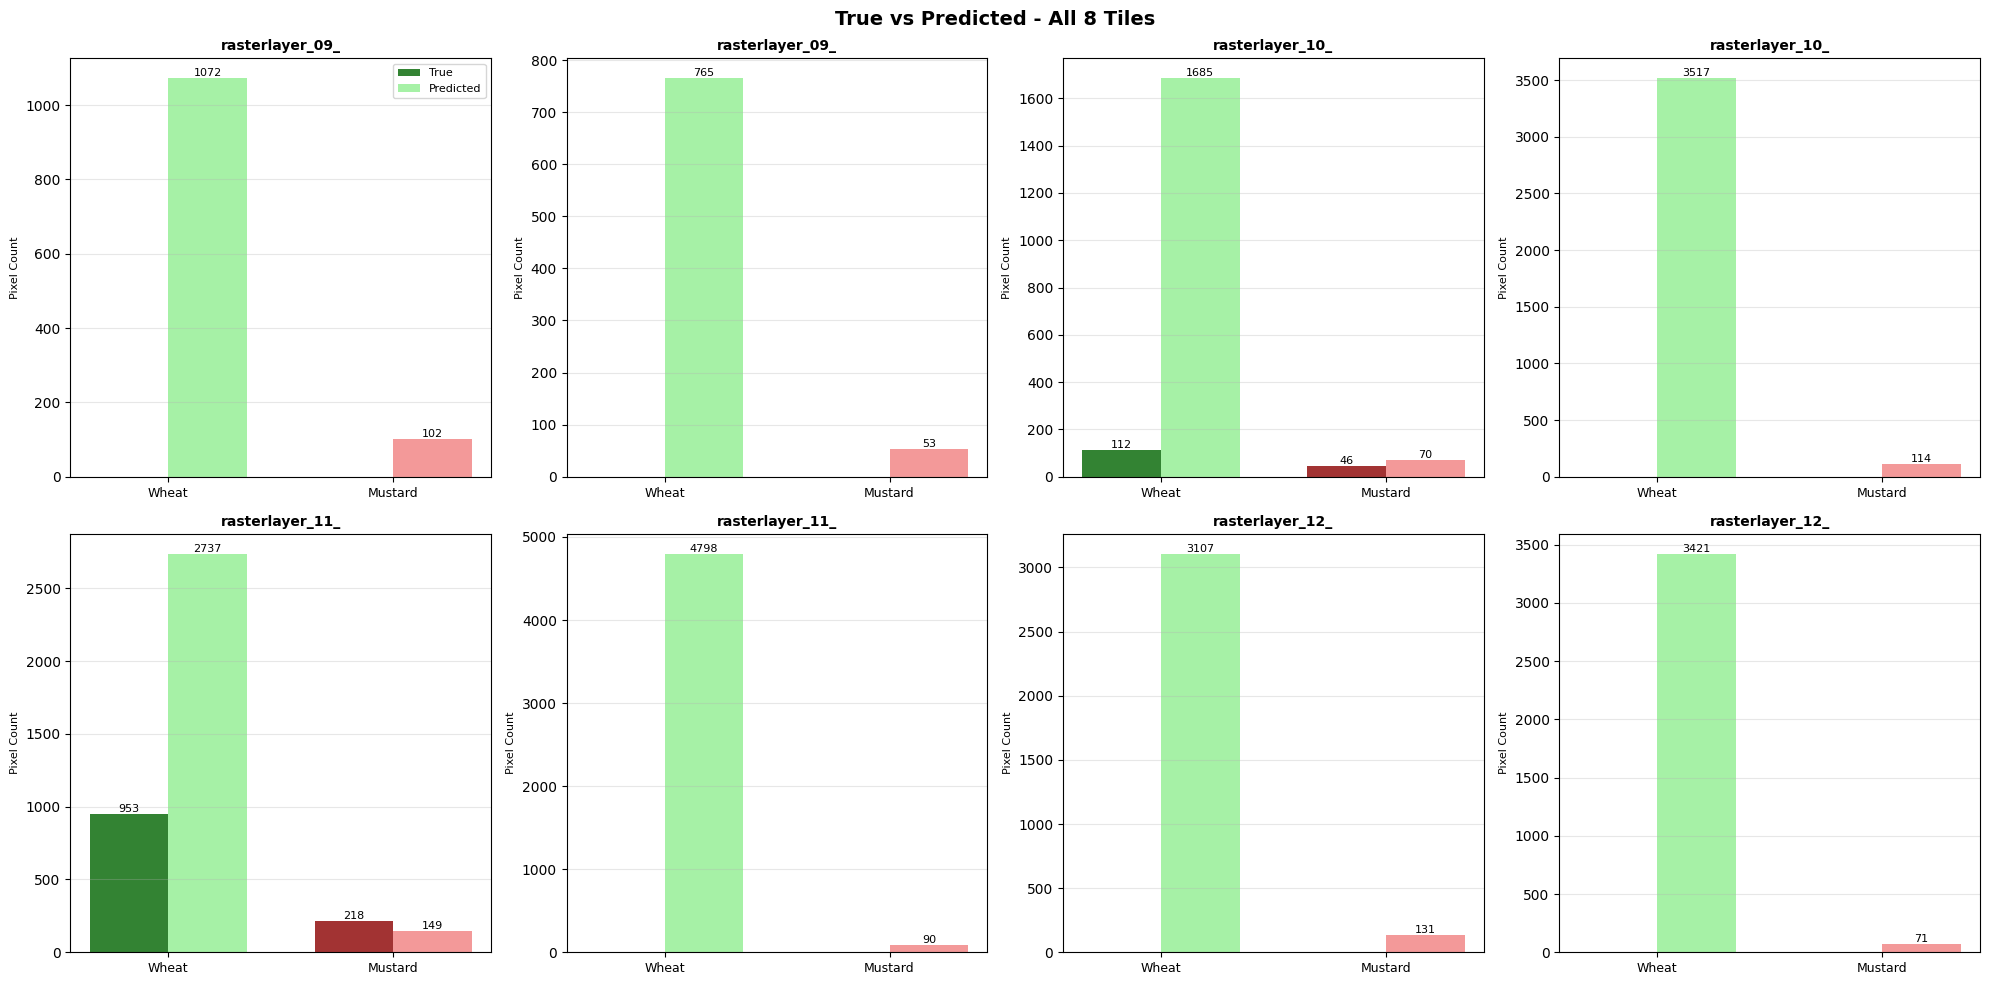

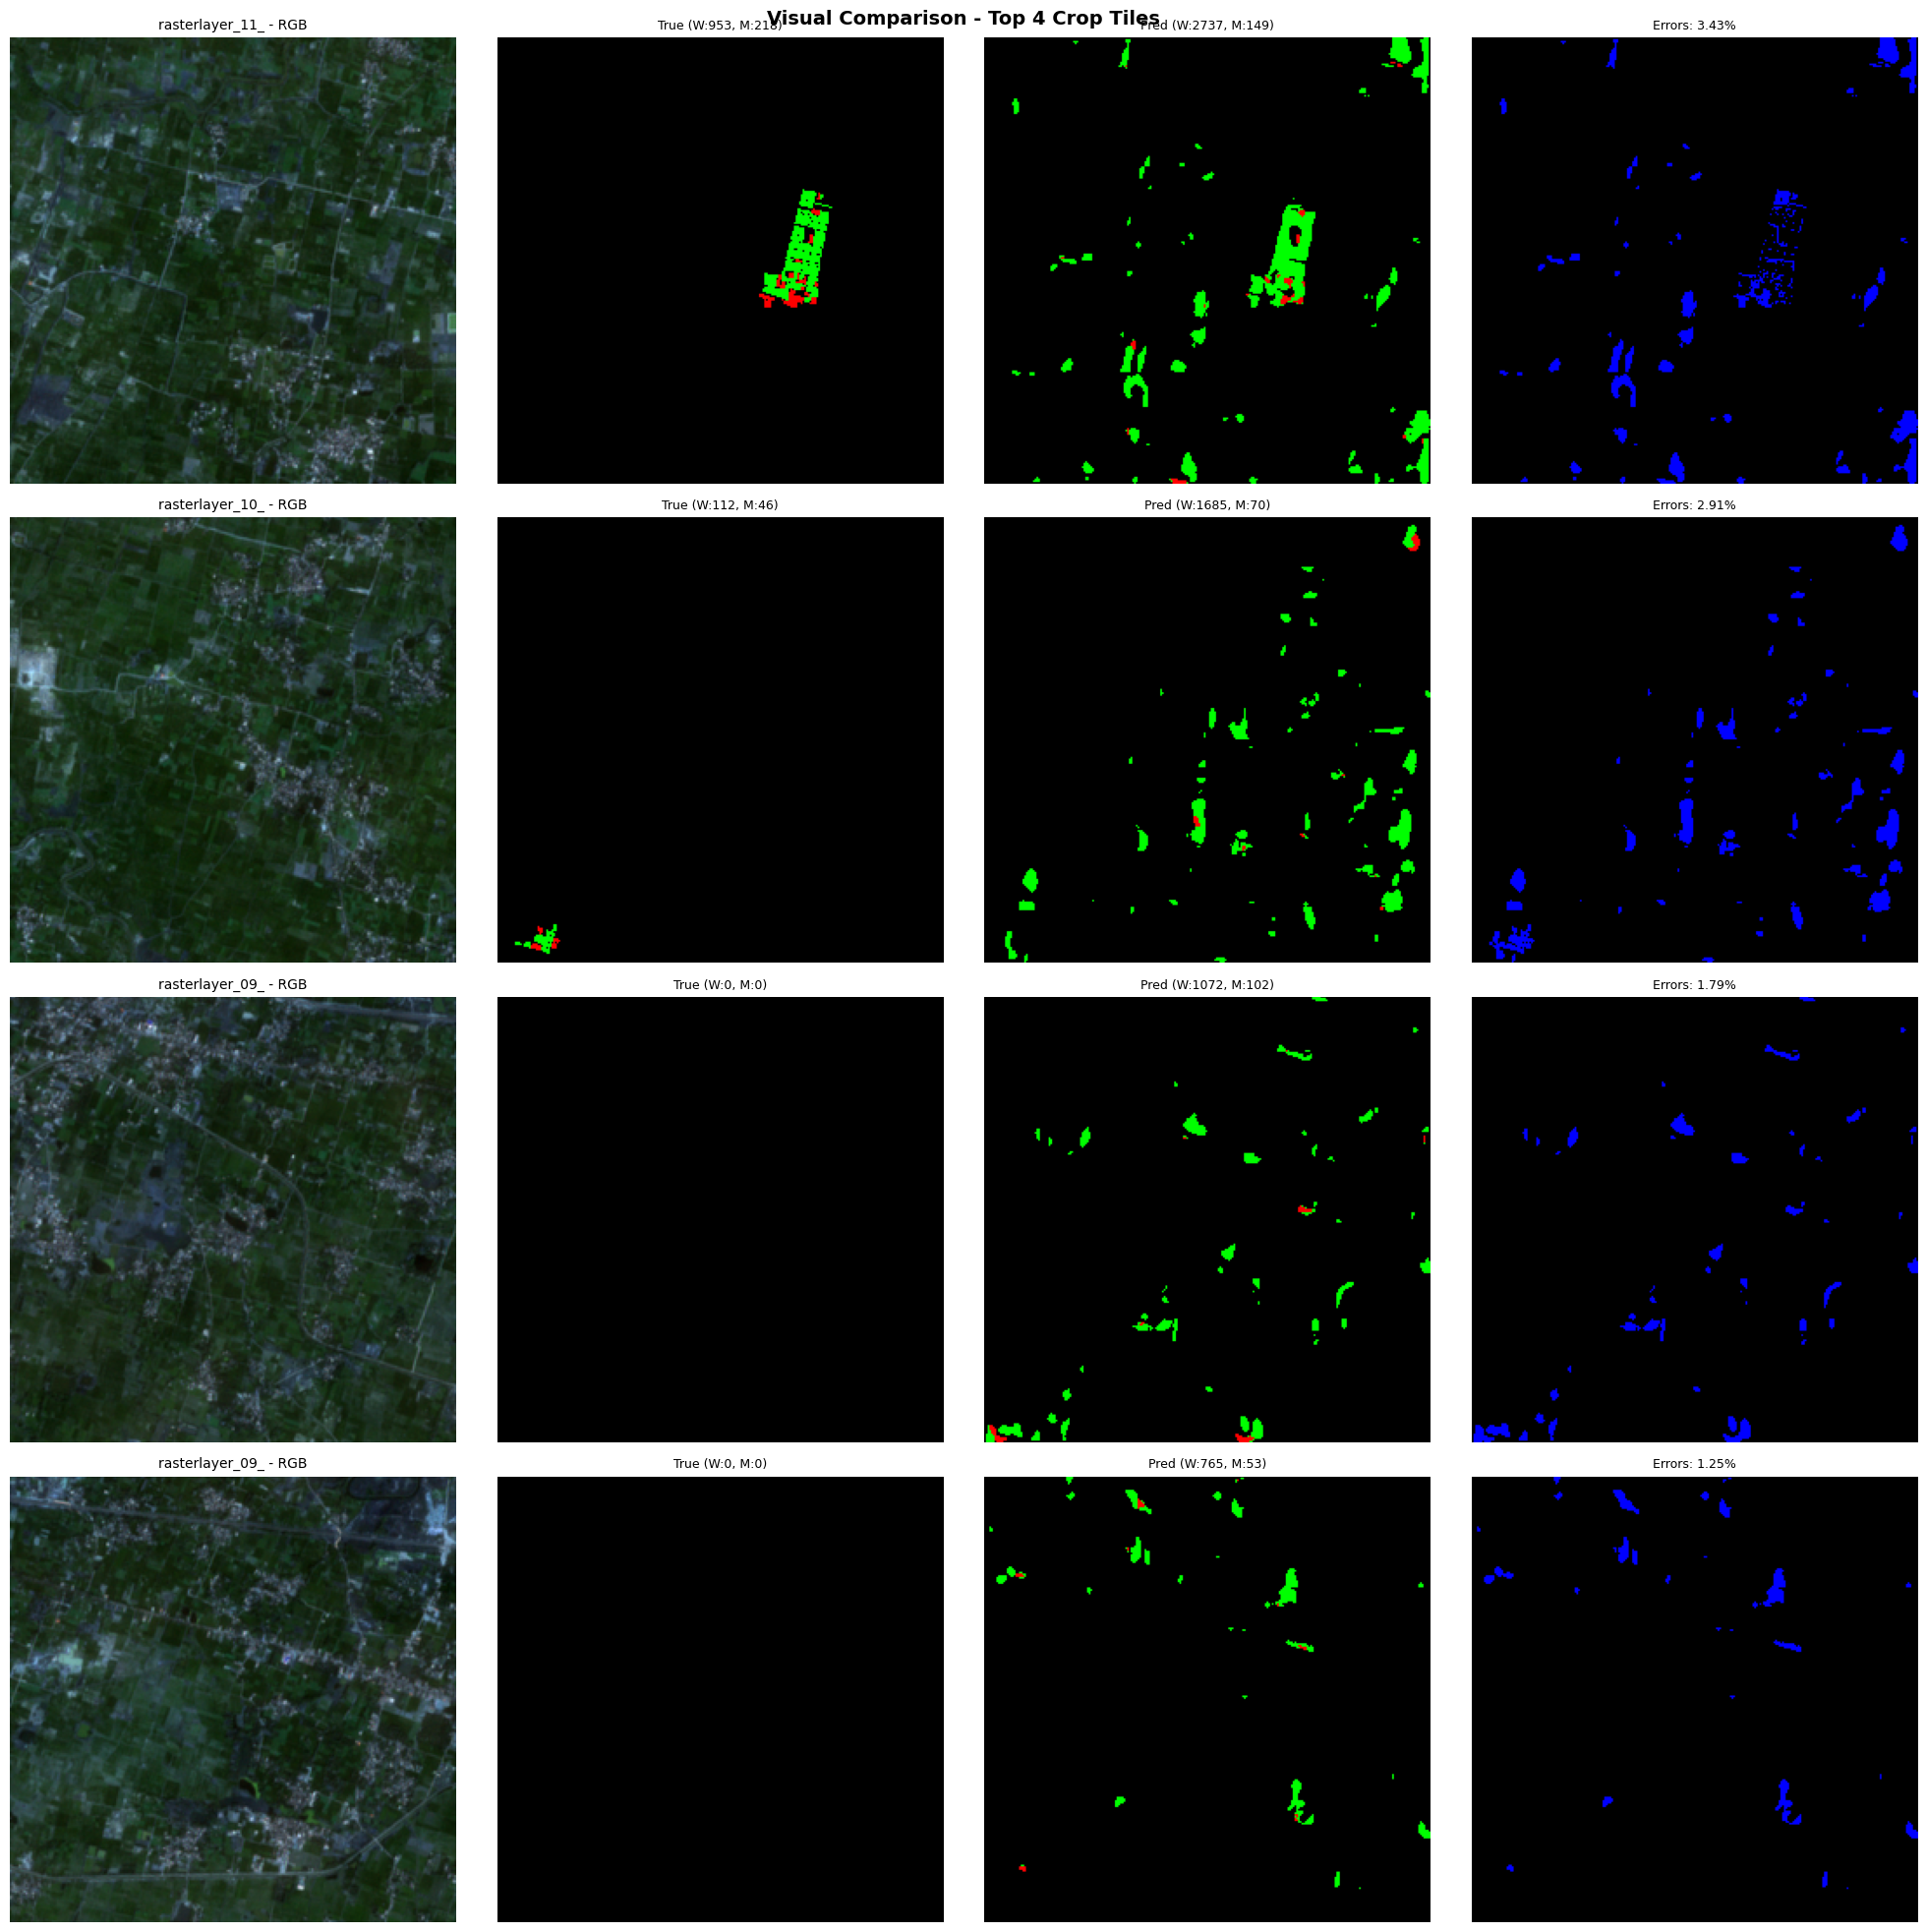

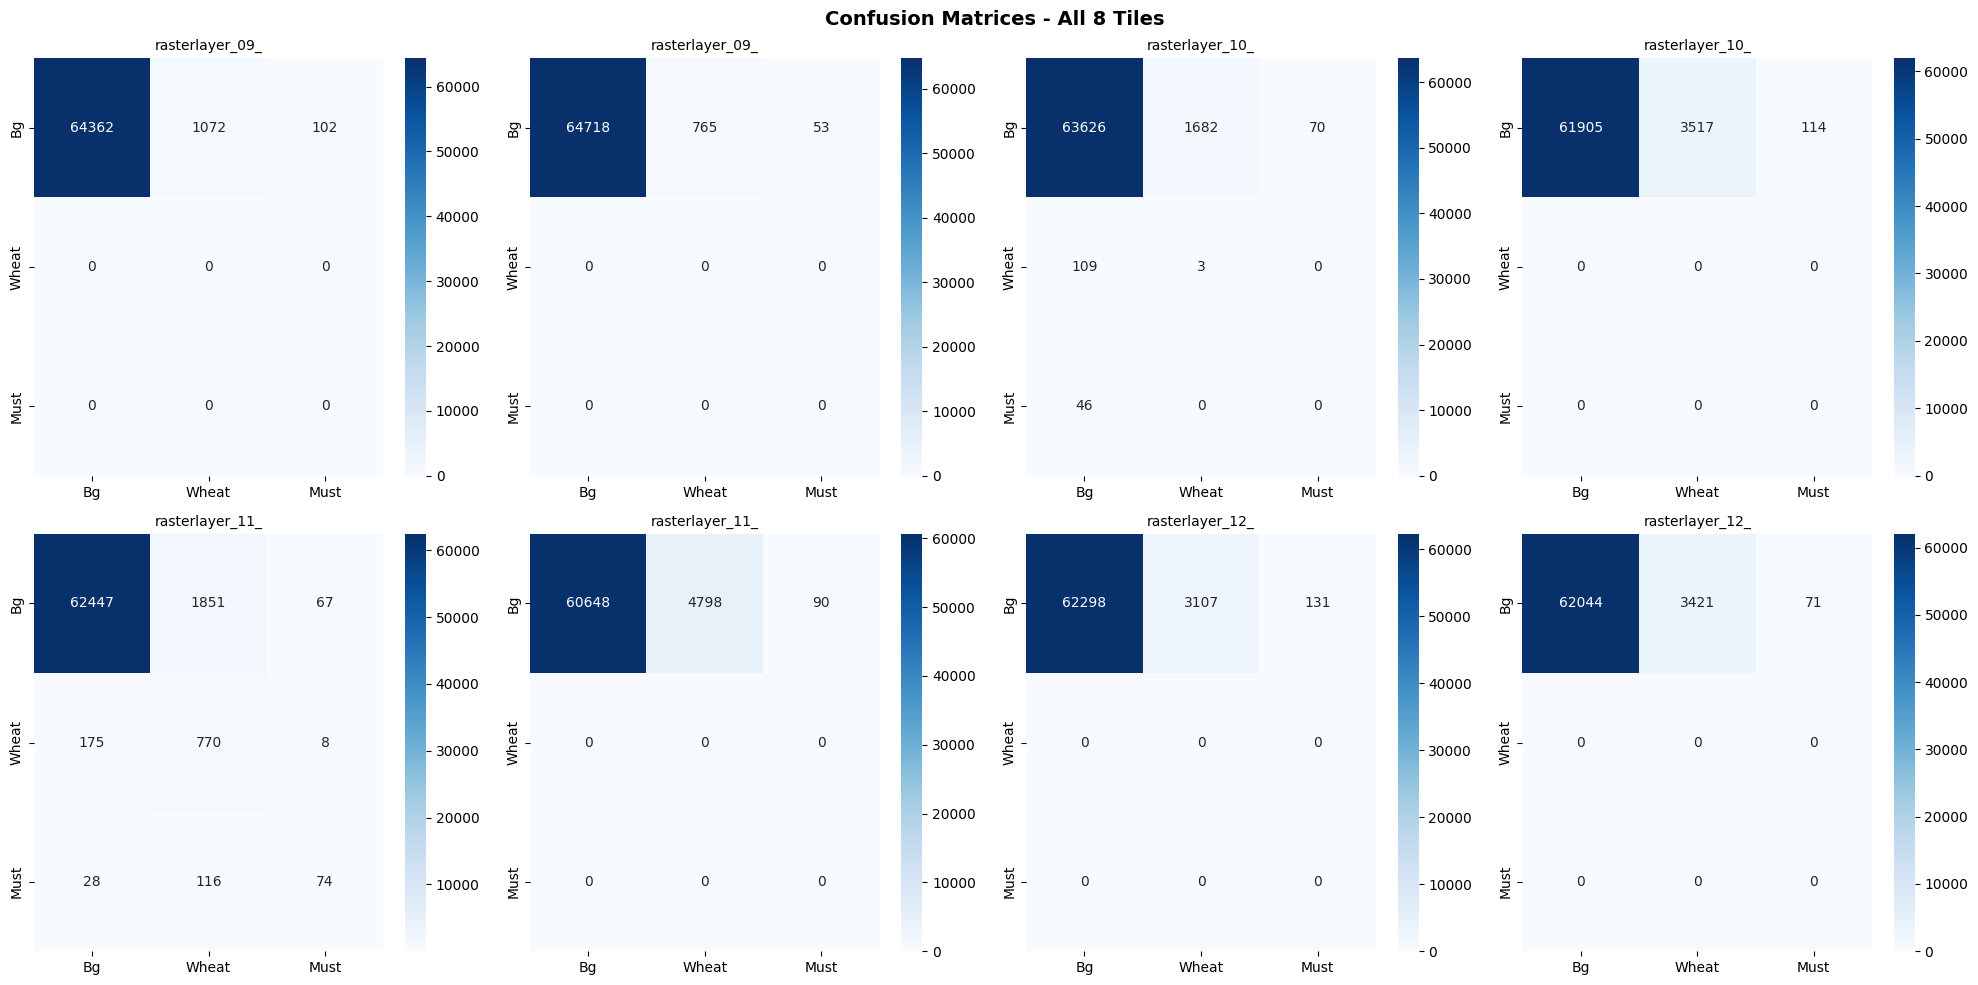


📊 SUMMARY STATISTICS

🌾 WHEAT:
   Total True: 1,065 pixels
   Total Pred: 21,102 pixels
   Difference: +20,037 pixels
   Accuracy: 1981.41%

🌿 MUSTARD:
   Total True: 264 pixels
   Total Pred: 780 pixels
   Difference: +516 pixels
   Accuracy: 295.45%

📊 Overall Average Accuracy: 95.92%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

image_folder = '/content/drive/MyDrive/Colab Notebooks/tiles_256/'
mask_folder = '/content/drive/MyDrive/Colab Notebooks/masks_256/'
model_path = '/content/drive/MyDrive/CropMapping/crop_segmentor.h5'

# List of tiles to process
all_tiles = [
    'rasterlayer_09_37.tif',
    'rasterlayer_09_38.tif',
    'rasterlayer_10_38.tif',
    'rasterlayer_10_37.tif',
    'rasterlayer_11_37.tif',
    'rasterlayer_11_38.tif',
    'rasterlayer_12_37.tif',
    'rasterlayer_12_38.tif'
]

print("GENERATING PREDICTIONS FOR ALL 8 TILES")

model = models.load_model(model_path)

def predict_tile(model, tile_path, patch_size=64, stride=32):
    """Predict on full tile using sliding window"""
    with rasterio.open(tile_path) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    h, w = img.shape[:2]
    full_pred = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.int32)

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patch_batch = np.expand_dims(patch, 0)

            pred = model.predict(patch_batch, verbose=0)[0]
            pred_classes = np.argmax(pred, axis=-1).astype(np.float32)

            full_pred[y:y+patch_size, x:x+patch_size] += pred_classes
            counts[y:y+patch_size, x:x+patch_size] += 1

    # Average overlapping predictions
    full_pred = np.divide(full_pred, np.maximum(counts, 1))
    return np.round(full_pred).astype(np.uint8)

print("\nGenerating predictions for all 8 tiles...")

results = []
predictions = {}

for tile_f in tqdm(all_tiles):
    tile_path = os.path.join(image_folder, tile_f)
    mask_f = tile_f.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_folder, mask_f)

    # Get prediction
    pred = predict_tile(model, tile_path)
    predictions[tile_f] = pred

    # Load true mask for comparison
    with rasterio.open(mask_path) as src:
        true = src.read(1)

    # Calculate metrics
    wheat_true = np.sum(true == 1)
    wheat_pred = np.sum(pred == 1)
    mustard_true = np.sum(true == 2)
    mustard_pred = np.sum(pred == 2)
    accuracy = np.sum(pred == true) / true.size * 100

    results.append({
        'tile': tile_f,
        'wheat_true': wheat_true,
        'wheat_pred': wheat_pred,
        'mustard_true': mustard_true,
        'mustard_pred': mustard_pred,
        'accuracy': accuracy
    })

# Output results table
print("\nPREDICTION RESULTS - ALL 8 TILES")
print(f"{'Tile':<20} {'Wheat True':>12} {'Wheat Pred':>12} {'Mustard True':>14} {'Mustard Pred':>14} {'Accuracy':>10}")

for r in results:
    print(f"{r['tile']:<20} {r['wheat_true']:>12} {r['wheat_pred']:>12} {r['mustard_true']:>14} {r['mustard_pred']:>14} {r['accuracy']:>9.2f}%")

# Bar charts for all tiles
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, r in enumerate(results):
    ax = axes[idx]
    categories = ['Wheat', 'Mustard']
    true_vals = [r['wheat_true'], r['mustard_true']]
    pred_vals = [r['wheat_pred'], r['mustard_pred']]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax.bar(x - width/2, true_vals, width, label='True',
                   color=['darkgreen', 'darkred'], alpha=0.8)
    bars2 = ax.bar(x + width/2, pred_vals, width, label='Predicted',
                   color=['lightgreen', 'lightcoral'], alpha=0.8)

    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=8)

    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=8)

    ax.set_title(f'{r["tile"][:15]}', fontsize=10, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=9)
    ax.set_ylabel('Pixel Count', fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    if idx == 0:
        ax.legend(loc='upper right', fontsize=8)

plt.suptitle('True vs Predicted - All 8 Tiles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Pick top 4 crop tiles for side-by-side masks
interesting_tiles = sorted(results, key=lambda x: x['wheat_true'] + x['mustard_true'], reverse=True)[:4]

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, r in enumerate(interesting_tiles):
    tile_f = r['tile']
    pred = predictions[tile_f]

    mask_f = tile_f.replace('.tif', '_mask.tif')
    with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
        true = src.read(1)

    with rasterio.open(os.path.join(image_folder, tile_f)) as src:
        img = src.read()
        img = np.transpose(img, (1, 2, 0))[:,:,:3]
        img = (img - img.min()) / (img.max() - img.min())

    # RGB Image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'{tile_f[:15]} - RGB', fontsize=10)
    axes[i, 0].axis('off')

    # True Mask
    true_disp = np.zeros((*true.shape, 3))
    true_disp[..., 1] = (true == 1) * 1.0
    true_disp[..., 0] = (true == 2) * 1.0
    axes[i, 1].imshow(true_disp)
    axes[i, 1].set_title(f'True (W:{r["wheat_true"]}, M:{r["mustard_true"]})', fontsize=9)
    axes[i, 1].axis('off')

    # Predicted Mask
    pred_disp = np.zeros((*pred.shape, 3))
    pred_disp[..., 1] = (pred == 1) * 1.0
    pred_disp[..., 0] = (pred == 2) * 1.0
    axes[i, 2].imshow(pred_disp)
    axes[i, 2].set_title(f'Pred (W:{r["wheat_pred"]}, M:{r["mustard_pred"]})', fontsize=9)
    axes[i, 2].axis('off')

    # Error Map
    error = (pred != true)
    error_disp = np.zeros((*error.shape, 3))
    error_disp[..., 2] = error * 1.0
    error_pct = np.sum(error) / true.size * 100
    axes[i, 3].imshow(error_disp)
    axes[i, 3].set_title(f'Errors: {error_pct:.2f}%', fontsize=9)
    axes[i, 3].axis('off')

plt.suptitle('Visual Comparison - Top 4 Crop Tiles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, r in enumerate(results):
    tile_f = r['tile']
    pred = predictions[tile_f]

    mask_f = tile_f.replace('.tif', '_mask.tif')
    with rasterio.open(os.path.join(mask_folder, mask_f)) as src:
        true = src.read(1)

    cm = confusion_matrix(true.flatten(), pred.flatten(), labels=[0, 1, 2])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Bg', 'Wheat', 'Must'],
                yticklabels=['Bg', 'Wheat', 'Must'])
    axes[idx].set_title(f'{tile_f[:15]}', fontsize=10)

plt.suptitle('Confusion Matrices - All 8 Tiles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSUMMARY STATISTICS")

total_wheat_true = sum(r['wheat_true'] for r in results)
total_wheat_pred = sum(r['wheat_pred'] for r in results)
total_mustard_true = sum(r['mustard_true'] for r in results)
total_mustard_pred = sum(r['mustard_pred'] for r in results)
avg_accuracy = np.mean([r['accuracy'] for r in results])

print(f"\nWHEAT:")
print(f"   Total True: {total_wheat_true:,} pixels")
print(f"   Total Pred: {total_wheat_pred:,} pixels")
print(f"   Difference: {total_wheat_pred - total_wheat_true:+,} pixels")
if total_wheat_true > 0:
    print(f"   Accuracy Ratio: {total_wheat_pred/total_wheat_true*100:.2f}%")

print(f"\nMUSTARD:")
print(f"   Total True: {total_mustard_true:,} pixels")
print(f"   Total Pred: {total_mustard_pred:,} pixels")
print(f"   Difference: {total_mustard_pred - total_mustard_true:+,} pixels")
if total_mustard_true > 0:
    print(f"   Accuracy Ratio: {total_mustard_pred/total_mustard_true*100:.2f}%")

print(f"\nOverall Average Accuracy: {avg_accuracy:.2f}%")

🌾 GENERATING PREDICTIONS FOR ALL 8 TILES



🎯 Generating predictions for all 8 tiles...


100%|██████████| 8/8 [00:42<00:00,  5.36s/it]



📊 PREDICTION RESULTS - ALL 8 TILES
Tile                   Wheat True   Wheat Pred   Mustard True   Mustard Pred   Accuracy
------------------------------------------------------------------------------------------
rasterlayer_09_37.tif            0          161              0             10     99.74%
rasterlayer_09_38.tif            0           57              0              2     99.91%
rasterlayer_10_38.tif          112           41             46              7     99.69%
rasterlayer_10_37.tif            0          121              0              0     99.82%
rasterlayer_11_37.tif          953          983            218            205     99.13%
rasterlayer_11_38.tif            0          229              0             61     99.56%
rasterlayer_12_37.tif            0          129              0              5     99.80%
rasterlayer_12_38.tif            0          194              0             16     99.68%


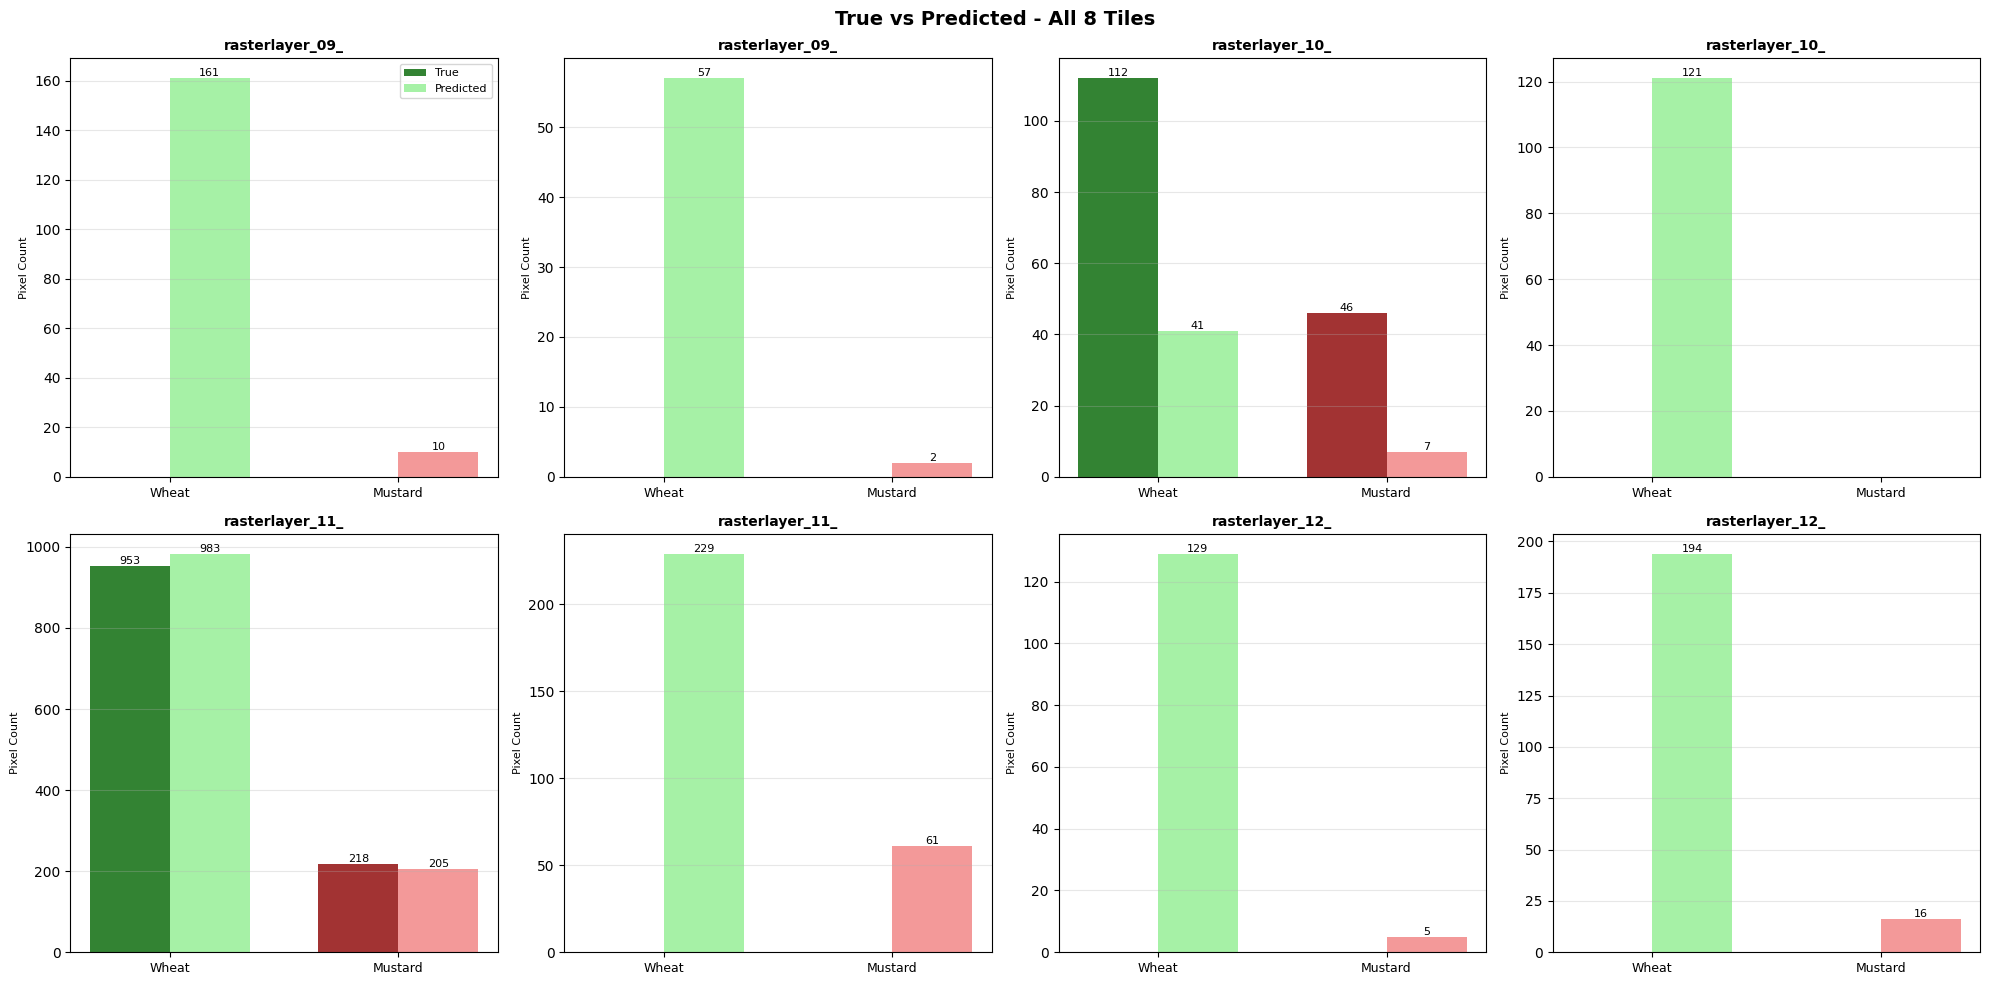

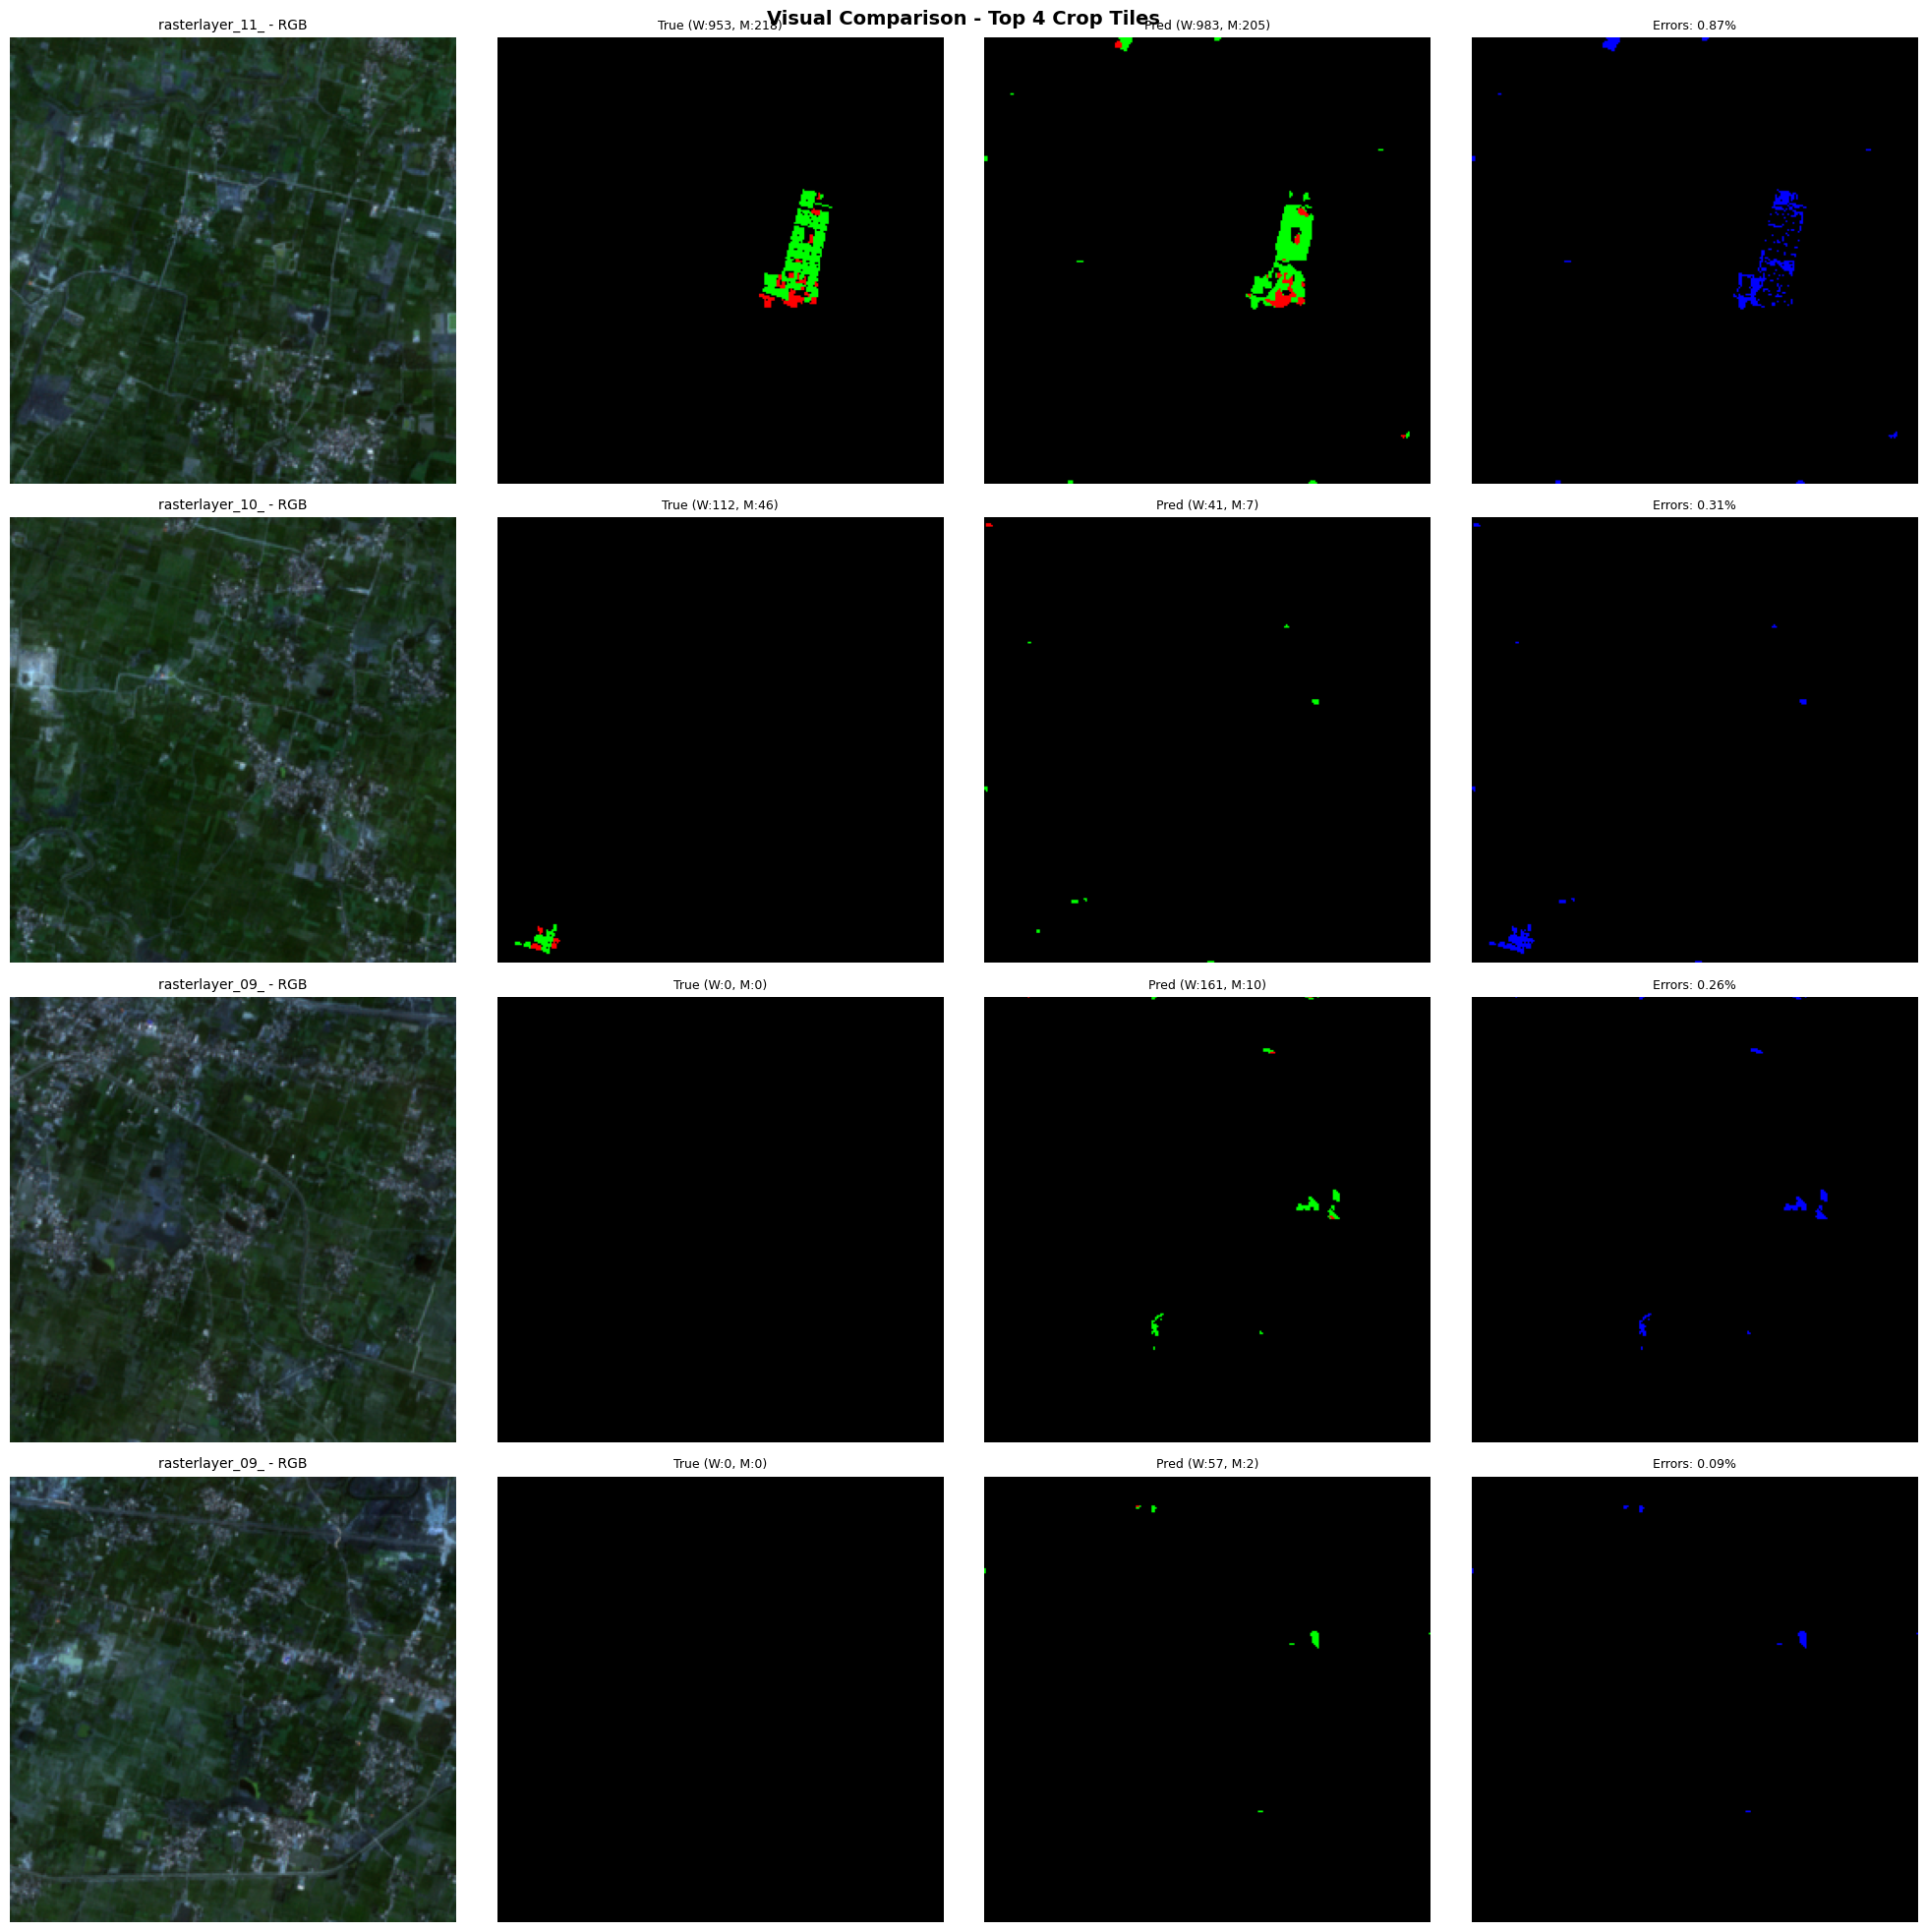

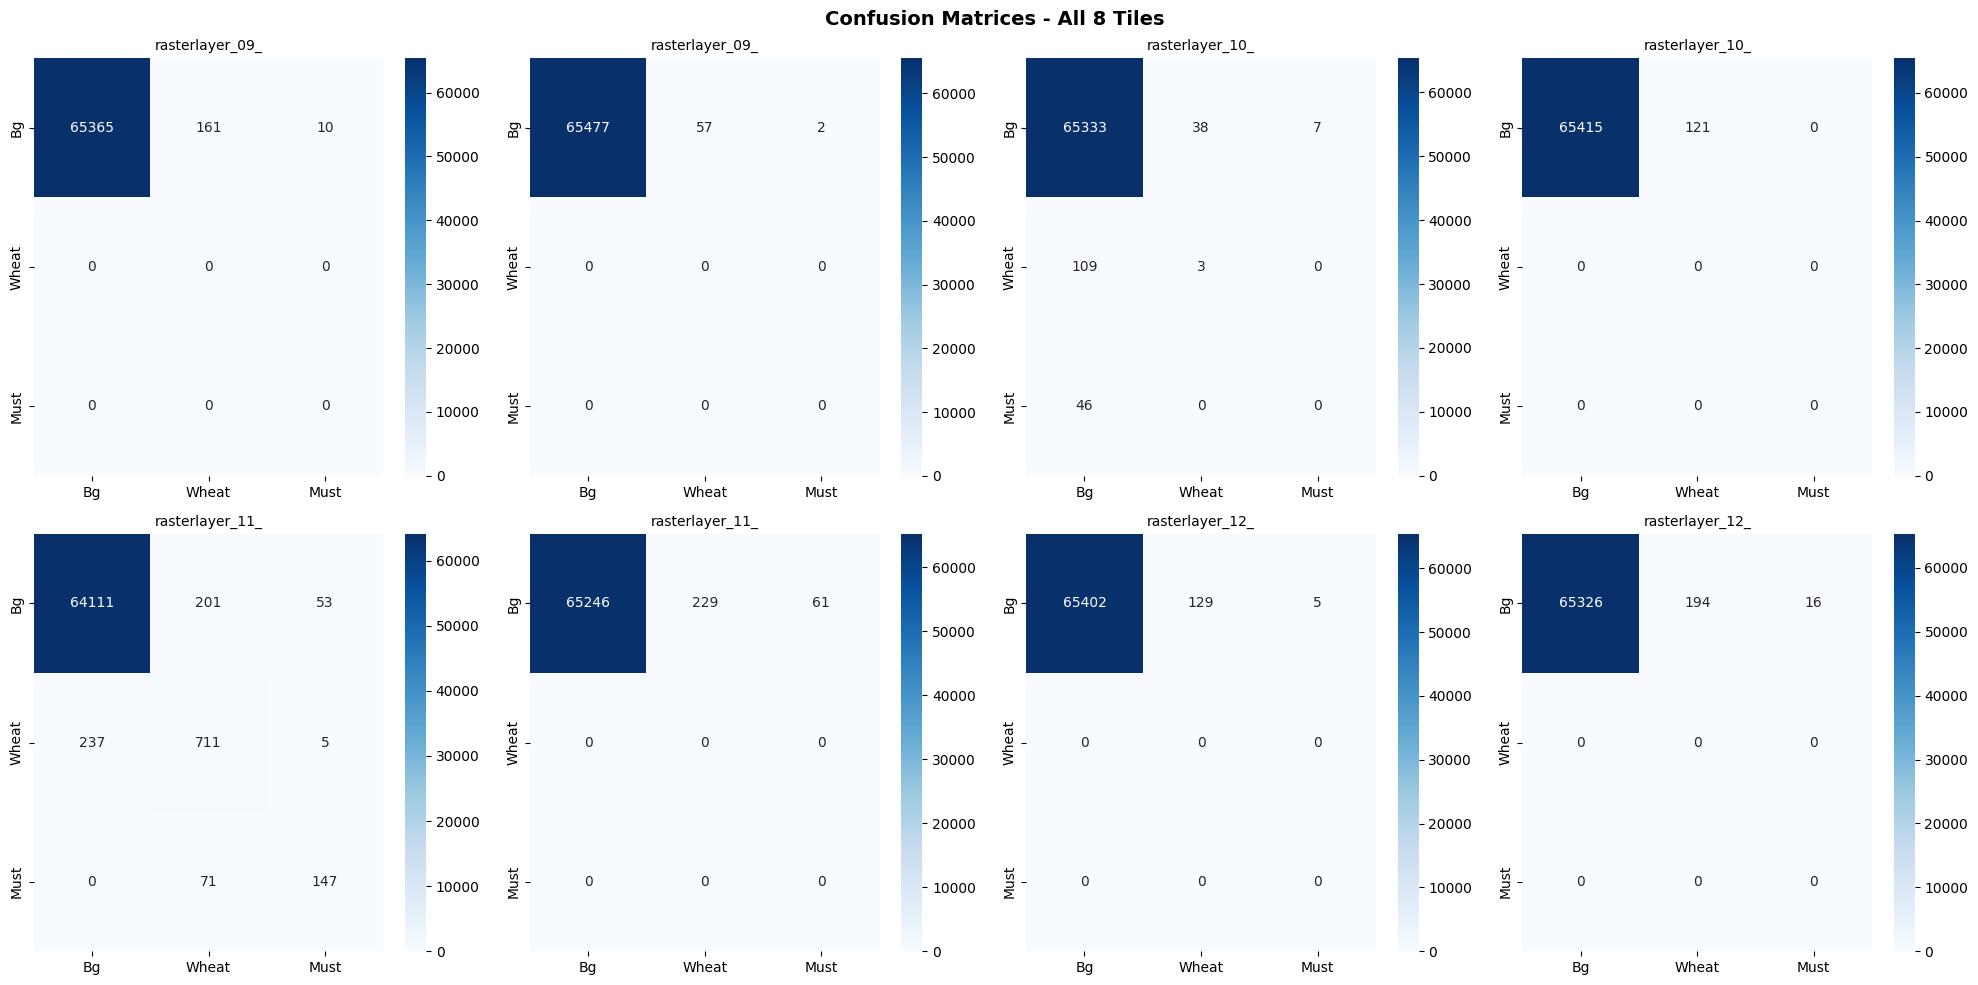


📊 SUMMARY STATISTICS

🌾 WHEAT:
   Total True: 1,065 pixels
   Total Pred: 1,915 pixels
   Difference: +850 pixels
   Accuracy: 179.81%

🌿 MUSTARD:
   Total True: 264 pixels
   Total Pred: 306 pixels
   Difference: +42 pixels
   Accuracy: 115.91%

📊 Overall Average Accuracy: 99.67%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

image_folder = '/content/drive/MyDrive/Colab Notebooks/tiles_256/'
mask_folder = '/content/drive/MyDrive/Colab Notebooks/masks_256/'
model_path = '/content/drive/MyDrive/CropMapping/crop_segmentor.h5'

all_tiles = [
    'rasterlayer_09_37.tif',
    'rasterlayer_09_38.tif',
    'rasterlayer_10_38.tif',
    'rasterlayer_10_37.tif',
    'rasterlayer_11_37.tif',
    'rasterlayer_11_38.tif',
    'rasterlayer_12_37.tif',
    'rasterlayer_12_38.tif'
]

model = models.load_model(model_path)

def predict_tile(model, tile_path, patch_size=64, stride=32):
    with rasterio.open(tile_path) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    h, w = img.shape[:2]
    full_pred = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.int32)

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patch_batch = np.expand_dims(patch, 0)
            pred = model.predict(patch_batch, verbose=0)[0]
            pred_classes = np.argmax(pred, axis=-1).astype(np.float32)
            full_pred[y:y+patch_size, x:x+patch_size] += pred_classes
            counts[y:y+patch_size, x:x+patch_size] += 1

    full_pred = np.divide(full_pred, np.maximum(counts, 1))
    return np.round(full_pred).astype(np.uint8)

results = []
predictions = {}

for tile_f in tqdm(all_tiles):
    tile_path = os.path.join(image_folder, tile_f)
    mask_f = tile_f.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_folder, mask_f)

    pred = predict_tile(model, tile_path)
    predictions[tile_f] = pred

    with rasterio.open(mask_path) as src:
        true = src.read(1)

    wheat_true, wheat_pred = np.sum(true == 1), np.sum(pred == 1)
    mustard_true, mustard_pred = np.sum(true == 2), np.sum(pred == 2)
    accuracy = np.sum(pred == true) / true.size * 100

    results.append({
        'tile': tile_f,
        'wheat_true': wheat_true,
        'wheat_pred': wheat_pred,
        'mustard_true': mustard_true,
        'mustard_pred': mustard_pred,
        'accuracy': accuracy
    })

print(f"{'Tile':<20} {'Wheat True':>12} {'Wheat Pred':>12} {'Mustard True':>14} {'Mustard Pred':>14} {'Accuracy':>10}")
for r in results:
    print(f"{r['tile']:<20} {r['wheat_true']:>12} {r['wheat_pred']:>12} {r['mustard_true']:>14} {r['mustard_pred']:>14} {r['accuracy']:>9.2f}%")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for idx, r in enumerate(results):
    ax = axes[idx]
    categories = ['Wheat', 'Mustard']
    true_vals = [r['wheat_true'], r['mustard_true']]
    pred_vals = [r['wheat_pred'], r['mustard_pred']]
    x, width = np.arange(len(categories)), 0.35
    ax.bar(x - width/2, true_vals, width, label='True', color=['darkgreen', 'darkred'], alpha=0.8)
    ax.bar(x + width/2, pred_vals, width, label='Predicted', color=['lightgreen', 'lightcoral'], alpha=0.8)
    ax.set_title(f'{r["tile"][:15]}')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    if idx == 0: ax.legend()

plt.tight_layout()
plt.show()

interesting_tiles = sorted(results, key=lambda x: x['wheat_true'] + x['mustard_true'], reverse=True)[:4]
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i, r in enumerate(interesting_tiles):
    tile_f = r['tile']
    pred = predictions[tile_f]
    mask_path = os.path.join(mask_folder, tile_f.replace('.tif', '_mask.tif'))
    with rasterio.open(mask_path) as src: true = src.read(1)
    with rasterio.open(os.path.join(image_folder, tile_f)) as src:
        img = np.transpose(src.read(), (1, 2, 0))[:,:,:3]
        img = (img - img.min()) / (img.max() - img.min())

    axes[i, 0].imshow(img)
    axes[i, 0].set_title('RGB')

    true_disp = np.zeros((*true.shape, 3))
    true_disp[..., 1], true_disp[..., 0] = (true == 1), (true == 2)
    axes[i, 1].imshow(true_disp)
    axes[i, 1].set_title('True Mask')

    pred_disp = np.zeros((*pred.shape, 3))
    pred_disp[..., 1], pred_disp[..., 0] = (pred == 1), (pred == 2)
    axes[i, 2].imshow(pred_disp)
    axes[i, 2].set_title('Predicted Mask')

    error = (pred != true)
    error_disp = np.zeros((*error.shape, 3))
    error_disp[..., 2] = error
    axes[i, 3].imshow(error_disp)
    axes[i, 3].set_title('Error Map')

plt.tight_layout()
plt.show()

total_wheat_true = sum(r['wheat_true'] for r in results)
total_wheat_pred = sum(r['wheat_pred'] for r in results)
total_mustard_true = sum(r['mustard_true'] for r in results)
total_mustard_pred = sum(r['mustard_pred'] for r in results)

print(f"\nWheat: True {total_wheat_true}, Pred {total_wheat_pred}, Diff {total_wheat_pred - total_wheat_true}")
print(f"Mustard: True {total_mustard_true}, Pred {total_mustard_pred}, Diff {total_mustard_pred - total_mustard_true}")
print(f"Average Accuracy: {np.mean([r['accuracy'] for r in results]):.2f}%")

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tqdm import tqdm



model_path = '/content/drive/MyDrive/CropMapping/crop_segmentor.h5'
image_folder = '/content/drive/MyDrive/Colab Notebooks/tiles_256/'
mask_folder = '/content/drive/MyDrive/Colab Notebooks/masks_256/'


all_tiles = [
    'rasterlayer_09_37.tif',
    'rasterlayer_09_38.tif',
    'rasterlayer_10_38.tif',
    'rasterlayer_10_37.tif',
    'rasterlayer_11_37.tif',
    'rasterlayer_11_38.tif',
    'rasterlayer_12_37.tif',
    'rasterlayer_12_38.tif'
]
def predict_tile(model, tile_path, patch_size=64, stride=32):
    with rasterio.open(tile_path) as src:
        img = src.read()
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))

    h, w = img.shape[:2]
    full_pred = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.int32)

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patch_batch = np.expand_dims(patch, 0)
            pred = model.predict(patch_batch, verbose=0)[0]
            pred_classes = np.argmax(pred, axis=-1).astype(np.float32)
            full_pred[y:y+patch_size, x:x+patch_size] += pred_classes
            counts[y:y+patch_size, x:x+patch_size] += 1

    full_pred = np.divide(full_pred, np.maximum(counts, 1))
    return np.round(full_pred).astype(np.uint8)

def calculate_metrics(y_true, y_pred, class_id):
    TP = np.sum((y_pred == class_id) & (y_true == class_id))
    FP = np.sum((y_pred == class_id) & (y_true != class_id))
    FN = np.sum((y_pred != class_id) & (y_true == class_id))
    TN = np.sum((y_pred != class_id) & (y_true != class_id))

    iou = TP / (TP + FP + FN + 1e-7)
    dice = 2 * TP / (2 * TP + FP + FN + 1e-7)
    precision = TP / (TP + FP + 1e-7)
    recall = TP / (TP + FN + 1e-7)
    f1 = 2 * precision * recall / (precision + recall + 1e-7)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-7)

    return {
        'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
        'IoU': iou, 'Dice': dice, 'Precision': precision,
        'Recall': recall, 'F1': f1, 'Accuracy': accuracy
    }

results = []

for tile_f in all_tiles:
    tile_path = os.path.join(image_folder, tile_f)
    mask_f = tile_f.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_folder, mask_f)

    pred = predict_tile(model, tile_path)

    with rasterio.open(mask_path) as src:
        true = src.read(1)

    wheat = calculate_metrics(true, pred, 1)
    mustard = calculate_metrics(true, pred, 2)
    bg = calculate_metrics(true, pred, 0)

    mean_iou = (wheat['IoU'] + mustard['IoU'] + bg['IoU']) / 3

    results.append({
        'tile': tile_f,
        'wheat': wheat,
        'mustard': mustard,
        'background': bg,
        'mean_iou': mean_iou
    })

print("=" * 100)
print("SEGMENTATION METRICS - ALL 8 TILES")
print("=" * 100)
print(f"{'Tile':<20} {'Class':<10} {'TP':>8} {'FP':>8} {'FN':>8} {'TN':>8} {'IoU':>8} {'Dice':>8} {'Prec':>8} {'Recall':>8} {'F1':>8} {'Acc':>8}")
print("-" * 120)

for r in results:
    for class_name, class_id in [('Wheat', r['wheat']), ('Mustard', r['mustard']), ('BG', r['background'])]:
        print(f"{r['tile']:<20} {class_name:<10} {class_id['TP']:>8} {class_id['FP']:>8} {class_id['FN']:>8} {class_id['TN']:>8} "
              f"{class_id['IoU']:>8.4f} {class_id['Dice']:>8.4f} {class_id['Precision']:>8.4f} "
              f"{class_id['Recall']:>8.4f} {class_id['F1']:>8.4f} {class_id['Accuracy']:>8.4f}")
    print("-" * 120)

print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

wheat_ious = [r['wheat']['IoU'] for r in results]
mustard_ious = [r['mustard']['IoU'] for r in results]
bg_ious = [r['background']['IoU'] for r in results]
mean_ious = [r['mean_iou'] for r in results]

print(f"\nAverage Wheat IoU: {np.mean(wheat_ious):.4f} ± {np.std(wheat_ious):.4f}")
print(f"Average Mustard IoU: {np.mean(mustard_ious):.4f} ± {np.std(mustard_ious):.4f}")
print(f"Average Background IoU: {np.mean(bg_ious):.4f} ± {np.std(bg_ious):.4f}")
print(f"Average Mean IoU: {np.mean(mean_ious):.4f} ± {np.std(mean_ious):.4f}")

crop_tiles = [r for r in results if r['tile'] == 'rasterlayer_11_37.tif']
if crop_tiles:
    print("\n" + "=" * 80)
    print("CROP TILE ONLY (rasterlayer_11_37.tif)")
    print("=" * 80)
    r = crop_tiles[0]
    print(f"Wheat - IoU: {r['wheat']['IoU']:.4f}, Dice: {r['wheat']['Dice']:.4f}, F1: {r['wheat']['F1']:.4f}")
    print(f"Mustard - IoU: {r['mustard']['IoU']:.4f}, Dice: {r['mustard']['Dice']:.4f}, F1: {r['mustard']['F1']:.4f}")
    print(f"Mean IoU: {r['mean_iou']:.4f}")







SEGMENTATION METRICS - ALL 8 TILES
Tile                 Class            TP       FP       FN       TN      IoU     Dice     Prec   Recall       F1      Acc
------------------------------------------------------------------------------------------------------------------------
rasterlayer_09_37.tif Wheat             0      161        0    65375   0.0000   0.0000   0.0000   0.0000   0.0000   0.9975
rasterlayer_09_37.tif Mustard           0       10        0    65526   0.0000   0.0000   0.0000   0.0000   0.0000   0.9998
rasterlayer_09_37.tif BG            65365        0      171        0   0.9974   0.9987   1.0000   0.9974   0.9987   0.9974
------------------------------------------------------------------------------------------------------------------------
rasterlayer_09_38.tif Wheat             0       57        0    65479   0.0000   0.0000   0.0000   0.0000   0.0000   0.9991
rasterlayer_09_38.tif Mustard           0        2        0    65534   0.0000   0.0000   0.0000   0.0000   0.